# Проект  "Прогнозирование снижения покупательской активности клиентов интернет-магазина"

Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.

Нужно построить модель, которая предскажет вероятность снижения покупательской активности клиента в следующие три месяца.В исследование нужно включить дополнительные данные финансового департамента о прибыльности клиента: какой доход каждый покупатель приносил компании за последние три месяца.Используя данные модели и данные о прибыльности клиентов, нужно выделить сегменты покупателей и разработать для них персонализированные предложения.  

Данные для работы находятся в нескольких таблицах:
 - market_file.csv - содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении,
 - market_money.csv - таблица с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом,
 - market_time.csv - таблица с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода,
 - money.csv - таблица с данными о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.
 
В рамках проекта необходимо решить следующие задачи:
 - Построить модель для предсказания снижения покупательской активности,
 - Используя данные модели и данные о прибыльности клиентов, выделить сегменты покупателей и разработать для них персонализированные предложения.

## Загрузка и изучение данных

In [1]:
#установим некоторые доп библиотеки
!pip install scikit-learn==1.1.3 -q
!pip install phik -q
!pip install shap -q
!pip install optuna -q
!pip install matplotlib==3.5.2 -q

In [2]:
#импортируем необходимые библиотеки,отключим предупреждения (в конце), 
#зададим формат вывода знаков после запятой

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import phik
import sklearn
import shap
import optuna
import os
from scipy import stats as st
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from optuna import distributions

# загружаем класс pipeline
from sklearn.pipeline import Pipeline

# загружаем классы для подготовки данных
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler,\
            MinMaxScaler, RobustScaler,LabelEncoder
from sklearn.compose import ColumnTransformer

# загружаем класс для работы с пропусками
from sklearn.impute import SimpleImputer

# загружаем функцию для работы с метриками
from sklearn.metrics import roc_auc_score,accuracy_score,precision_score, recall_score

# загружаем нужные модели
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC


import warnings
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.2f}'.format

In [3]:
#функция для загрузки данных в датафрейм
def download(file,sep=','):
    
    data = pd.DataFrame()
    
    path_1 = '/datasets/' + file + '.csv'
    path_2 = 'https://code.s3.yandex.net/datasets/' + file + '.csv'

    if os.path.exists(path_1):
        data = pd.read_csv(path_1, sep)
    elif os.path.exists(path_2):
        data = pd.read_csv(path_2, sep)
    else:
        print('Something is wrong')
        
    return data 

In [4]:
#загрузим данные из файла о поведении покупателей
market_file = download('market_file')
#выведем первые 5 строк
market_file.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.40,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.40,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.90,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.20,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.10,3,1064,0.94,Товары для детей,3,2,3,2


В данных о поведении покупателей на сайте 13 столбцов, опечатки в столбце Тип сервиса, в столбце Макертинговая активность за 6 мес не целое число

In [5]:
#загрузим данные из файла с данными о выручке
market_money = download('market_money')

#выведем первые 5 строк
market_money.head()

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.00
1,215348,текущий_месяц,"3,293.10"
2,215348,предыдущий_месяц,0.00
3,215349,препредыдущий_месяц,"4,472.00"
4,215349,текущий_месяц,"4,971.60"


В таблице с данными о выручке на первый взгляд все корректно

In [6]:
#загрузим данные из файла с данными о времени
market_time = download('market_time')

#выведем первые 5 строк
market_time.head()

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


В таблице с данными о времени опечатка в значении "предыдущий месяц" - нужно будет ее устранить

In [7]:
#загрузим данные из файла с данными о прибыли
money = download('money',sep=';')

#выведем первые 5 строк
money.head()

,id,Прибыль
0,215348,"0,98"
1,215349,"4,16"
2,215350,"3,13"
3,215351,"4,87"
4,215352,"4,21"


В таблице с данными о прибыли знак разделения целого и дробной части запятая, а не точка, поэтому данные в столбце Прибыль подгрузились как строковые значения, а не числовые - нужно будет заменть запятую на точку.

## Предобработка данных

In [8]:
#выведем общую информацию из файла о поведении покупателей
market_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

В данных 13 столбцов, 1300 строк, пропуски отсутствуют. Тип данных соответствует содержанию.

In [9]:
#выведем общую информацию из файла о выручке
market_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


В данных 3 столбца, 3900 строк, пропуски отсутствуют, тип данных корректный

In [10]:
#выведем общую информацию из файла о времени
market_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


В файле 3 столбца,2600 строк, пропуски отсутствуют, тип данных корректный

In [11]:
#выведем общую информацию из файла о прибыли
money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       1300 non-null   int64 
 1   Прибыль  1300 non-null   object
dtypes: int64(1), object(1)
memory usage: 20.4+ KB


В данных 2 столбца, 1300 строк, пропуски отсутствуют, тип данных столбца Прибыль некорретный - причина в разделении целого и дробной части числа запятой, а не точкой.

Выведем уникальные значения всех категориальных данных, параллельно проверяя на опечатки (неявные дубликаты) и некорректности

In [12]:
#выведем уникальные значение из файла о покупателях
for column in market_file.select_dtypes(exclude='number'):
    print (f'{column}:\n{market_file.select_dtypes(exclude="number")[column].unique()}',end = '\n\n')

Покупательская активность:
['Снизилась' 'Прежний уровень']

Тип сервиса:
['премиум' 'стандартт' 'стандарт']

Разрешить сообщать:
['да' 'нет']

Популярная_категория:
['Товары для детей' 'Домашний текстиль' 'Косметика и аксесуары'
 'Техника для красоты и здоровья' 'Кухонная посуда'
 'Мелкая бытовая техника и электроника']



In [13]:
#выведем уникальные значение из файла о выручке
market_money['Период'].unique()

array(['препредыдущий_месяц', 'текущий_месяц', 'предыдущий_месяц'],
      dtype=object)

In [14]:
#выведем уникальные значения из файла с данными о времени
market_time['Период'].unique()

array(['текущий_месяц', 'предыдцщий_месяц'], dtype=object)

Итого, необходимо скорректировать следующие опечатки и некорректности:
 - в файле о прибыли нужно заменить разделитель целого и дробной части числа с запятой на точку,
 - в файле о поведении покупателей опечатки  в столбце Тип сервиса (в значении стандарт 2 т на конце), 
 - в таблице с данными о времени опечатка в значении "предыдущий месяц". Устраним все ошибки, проверим тип данных в файле с Прибылью

In [15]:
#поменяем запятые на точки в данных о прибыли,устраним опечатки
money['Прибыль'] = money['Прибыль'].replace(',','.',regex=True).astype('float')
market_file['Тип сервиса'] = market_file['Тип сервиса'].replace('стандартт','стандарт',regex=True)
market_time['Период'] = market_time['Период'].replace('предыдцщий_месяц','предыдущий_месяц',regex=True)

#выведем инфо по файлу фермы
money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


Произвели устранение опечаток,некорректностей.

Далее проведем работу по поиску явных дубликатов

In [16]:
# зададим функцию поиска явных дубликатов и выведем для каждого файла
def duplicat(data,name):
    print(f'Кол-во дубликатов в файле "{name}" - {data.duplicated().sum()}')

In [17]:
# выведем явные дубликаты для каждого файла

a={'данные о поведении покупателей':market_file,'данные о выручке':market_money,\
        'данные о времени':market_time,'данные о прибыли':money}

for key,value  in a.items():
    duplicat(value,key)

Кол-во дубликатов в файле "данные о поведении покупателей" - 0
Кол-во дубликатов в файле "данные о выручке" - 0
Кол-во дубликатов в файле "данные о времени" - 0
Кол-во дубликатов в файле "данные о прибыли" - 0


Также проверим дублируется ли id в файле о покупателях, о прибыли, встречается ли id больше 2-х раз в файле со временем (2 значения на каждого покупателя- текущий и предыдущий месяц) и больше 3-х в файле с выручкой(3 значения на каждого покупателя- текущий,предыдущий и препредыдущий месяц)

In [18]:
# зададим функцию для вывода максимальных значений повтора id
def value_counts(data):
    print(data['id'].value_counts(ascending=False).head(1))

In [19]:
#максимальныe значений повтора id

for key,value  in a.items():
    print(key)
    value_counts(value)
    print(' ')

данные о поведении покупателей
215348    1
Name: id, dtype: int64
 
данные о выручке
215349    3
Name: id, dtype: int64
 
данные о времени
215349    2
Name: id, dtype: int64
 
данные о прибыли
215348    1
Name: id, dtype: int64
 


**По итогу проведенной предобработки данных:**
 - пропуски в данных отсутствуют,
 - явные дубликаты отсутствуют, обработаны неявные дубликаты,
 - все данные приведены к корректному типу

## Исследовательский анализ данных

### Данные о покупателях

Проведем исследовательский анализ данных клиентов с покупательской активностью не менее трёх месяцев. Это клиенты, которые осуществляли покупки в каждые из 3-х месяцев: таких клиентов можно выявить путем анализа файла с выручкой


In [20]:
#найдем клиентов, по которым отсутствует выручка хотя бы 1 месяц из 3-х
cust = market_money.query('Выручка==0')
cust['id'].unique()

array([215348, 215357, 215359])

Покупателей, которые не покупали 3 месяца подряд всего 3 - это покупатели с id 215348, 215357, 215359

Создадим новый файл без учета тех 3-х покупателей, которые не покупали в каждый из 3-х месяцев. Далее анализ будет проводиться только по этим данным

In [21]:
market_file = market_file.query('id not in[215348, 215357, 215359]')

Проанализируем  распределение всех признаков, включая целевой, на всей выборке, а затем в зависимости от покупательской активности. Сначала рассмотрим качественные данные датасета о покупателях

In [22]:
#фукнция для построения круговой диаграммы
def pie(df,column):
    plt.pie(df.groupby(column)[column].count(), autopct='%.1f%%', radius=1)
    plt.title('Распределение по '+column,fontsize=12);
    plt.legend(labels = df[column].unique(),loc='upper left', bbox_to_anchor=(1.0, 1.0));
    plt.show()

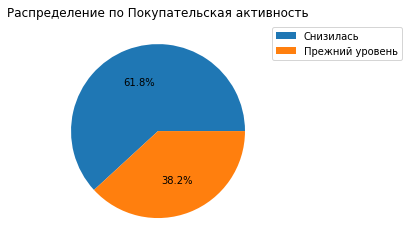

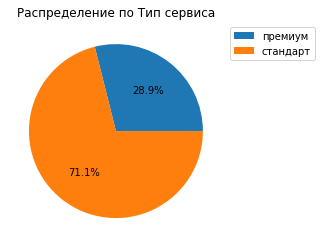

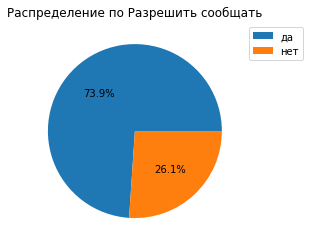

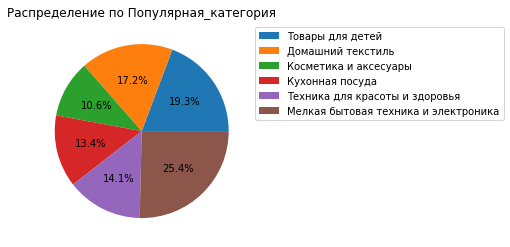

In [23]:
#выведем круговые диаграммы на одном графике для всех данных
for column in  market_file.select_dtypes(exclude='number'):
    pie(market_file.select_dtypes(exclude='number'),column)

На основании круговых диаграмм выявлено следующее:
 - у 62% покупателей активность снизилась и только у 38% осталась на прежнем уровне,
 - преобладает тип сервиса стандарт - 71%, соответственно, премиум 29%,
 - согласие на рассылку дополнительных предложений о товаре дало 74%, не дало - 26%,
 - распределение по наиболее популярным категориям следующее:мелкая и бытовая техника - 25% покупателей, далее товары для детей(19%), меньше всего у косметики и аксессуаров - 11%.

Т.о. при оценке категориальных признаков, видим, что данные несбалансированы.

Оценим распределение в разрезе покупательской активности

In [24]:
#функция для круговой диаграммы с выводом значений в разрезе снижения/неснижения покупат активности
def pie_1(df,column):
    fig, ax = plt.subplots(figsize = (20, 5))
    
    ax = plt.subplot(1, 2, 1)
    plt.pie(df[df['Покупательская активность']=='Снизилась'].groupby(column)[column].count(),\
            autopct='%.1f%%', radius=0.75);
    plt.xlabel('Сниженная покупательская активность', fontsize=12);
    plt.legend(labels = df[column].unique(),loc='upper left', bbox_to_anchor=(1.5, 1.0));

    ax = plt.subplot(1, 2, 2)
    plt.pie(df[df['Покупательская активность']!='Снизилась'].groupby(column)[column].count(),\
            autopct='%.1f%%', radius=0.75);
    plt.xlabel('Прежняя покупательская активность', fontsize=12);
    
    fig.suptitle('Распределение покупателей по значению '+column,fontsize=14)
    plt.subplots_adjust(wspace=1,hspace = 1)
    plt.show()

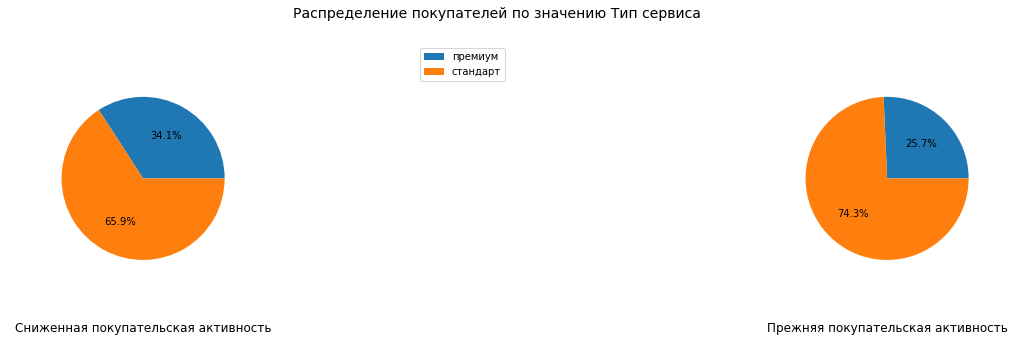

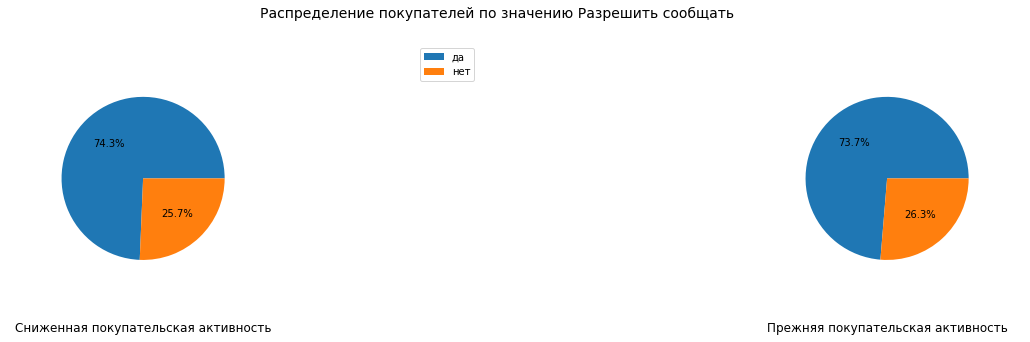

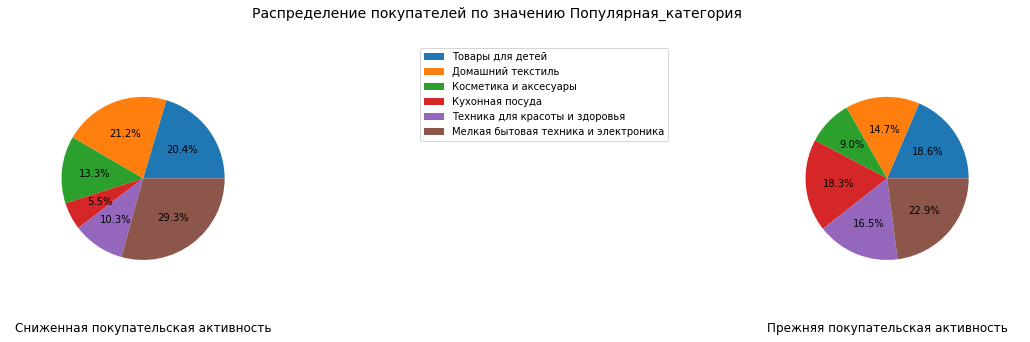

In [25]:
#выведем диаграммы
for column in  market_file.drop(['id','Покупательская активность'],axis=1)\
                .select_dtypes(exclude='number').columns.tolist():
    pie_1(market_file.select_dtypes(exclude='number'),column)

У покупателей со сниженной покупательской активностью схожее распределение по типу сервиса и разрешению сообщать о новых предожениях, по типу сервиса покупателей со сниженной активностью и премиум-подписке даже больше. 

При этом распределение по популярной категории расходится:доля типа Мелкая бытовая техника и электроника выше, как и доля Товаров для детей и доля Домашнего текстиля - совокупная доля по данным категориям почти 71%, у покупателей с прежней активностью - 56%, доля Кухонной посуды более чем в 3 раза меньше, чем у покупателей с прежней акивностью.

Далее проанализируем данные по количественным показателям данных о покупателях 

In [26]:
market_file.drop(['id'],axis=1).describe().T

,count,mean,std,min,25%,50%,75%,max
Маркет_актив_6_мес,"1,297.00",4.25,1.02,0.90,3.70,4.20,4.90,6.60
Маркет_актив_тек_мес,"1,297.00",4.01,0.70,3.00,4.00,4.00,4.00,5.00
Длительность,"1,297.00",602.99,249.10,121.00,410.00,607.00,806.00,"1,079.00"
Акционные_покупки,"1,297.00",0.32,0.25,0.11,0.17,0.24,0.30,0.99
Средний_просмотр_категорий_за_визит,"1,297.00",3.27,1.35,1.00,2.00,3.00,4.00,6.00
Неоплаченные_продукты_штук_квартал,"1,297.00",2.84,1.97,0.00,1.00,3.00,4.00,10.00
Ошибка_сервиса,"1,297.00",4.18,1.95,0.00,3.00,4.00,6.00,9.00
Страниц_за_визит,"1,297.00",8.19,3.98,1.00,5.00,8.00,11.00,20.00


Исходя из стат данных по столбцам видим следующее:
 - Маркет_актив_6_мес: среднее значение 4.25 в целом близко к медианному - 4.2,минимальное - 0.9, значения лежат в интервале от 0.9 до 6.6 коммуникаций в среднем,
 - Маркет_актив_тек_мес: значение коммуникаций за текущий месяц отличаются от средних за 6 последних - минимальные значения выросли до 3-х, но максимальные снизились до 5.
 - Длительность:с момента регистрации покупателя на сайте прошло от 121 до 1079 дней, среднее значение и медиана близки - 603 и 607 соответственно,
 - Акционные_покупки: доля составляет от 11% до 99%, при этом среднее значение выше медианы - 32% и 24% соответственно,
 - Средний_просмотр_категорий_за_визит: значения в интервале от 1 до 6, среднее значение и медиана близки - 3.27 и 3 соответственно,
 - Неоплаченные_продукты_штук_квартал:значения в интервале от 0 до 10, среднее и медиана близки - 2.84 и 3 соответственно,
 - Ошибка_сервиса: значение в интервале от 0 до 9,среднее и медиана близки - 4.18 и 4 соответственно,
 - Страниц_за_визит: значение в интервале от 1 до 20,среднее и медиана близки - 8.19 и 8 соответственно.
 
Построим гистограммы распределения количественных признаков и диаграммы размаха. Для визуальности будет выводить по 4 признака на одном графике

In [27]:
#функция для построения гистограммы распределения и диаграммы размаха
def hist_box(df,column):
    fig, ax = plt.subplots(figsize = (20, 5))
    
    df.plot(y =column,\
          kind ='hist', ec='black', bins = 30, grid = True,figsize=(18,4),ax = plt.subplot(1, 2, 1));
    plt.ylabel('Кол-во покупателей', fontsize=12);
    plt.xlabel(column, fontsize=12);
    plt.xlim((df[column].min()*0.9,df[column].max()*1.1))

    df.boxplot(column,ax = plt.subplot(1, 2, 2))
    plt.ylim((df[column].min()*0.9,df[column].max()*1.1))
    plt.ylabel(column, fontsize=12);
    
    fig.suptitle('Распределение и размах по значению '+column)
    plt.subplots_adjust(wspace=0.5,hspace = 0.5)
    plt.show()
  

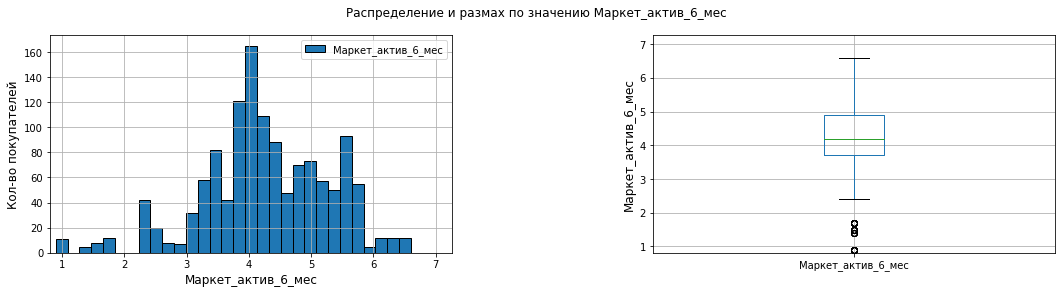

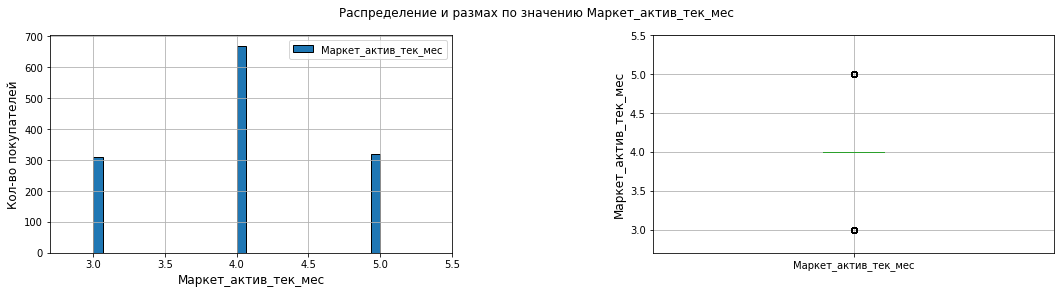

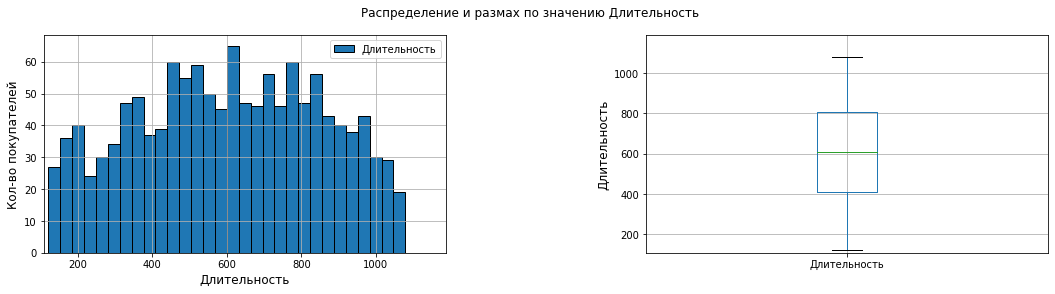

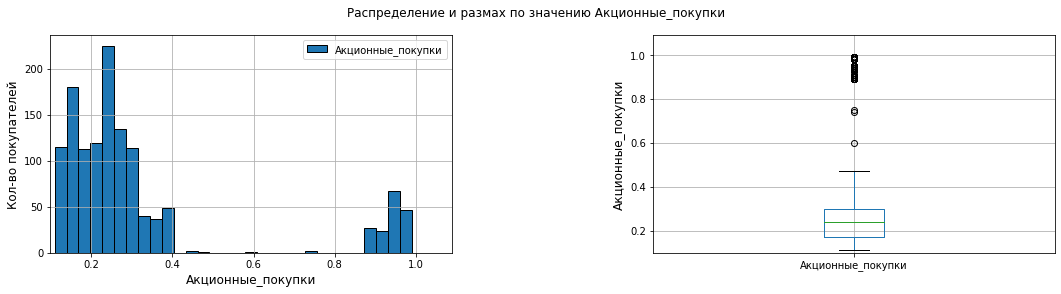

In [28]:
#выведем гистограмму распределения и диаграмму размаха(первые 4 признака)
for column in  market_file.drop(['id'],axis=1).select_dtypes(include='number').columns.tolist()[:4]:
    hist_box(market_file.drop(['id'],axis=1).select_dtypes(include='number'),column)

 - Маркет_актив 6 мес: 4-ре значения менее 2-х оцениваются как выбросы, данные находятся преимузественно в диапазоне от 2.2 до 6.6,
 - Маркет_актив_тек_мес: представлены всего 3 значениями - 3,4 и 5 раз, причем наиболее частое - 4.
 - Длительность:выбросы отсутствуют, распределение напоминает нормальное
 - Акционные_покупки: значения расположены в 2-х кластерах, большая часть значение в интервале до 0.4,прочие значения более редкие - возможно стоит преобразовать данный количественный признак в категориальный,

далее остальные признаки

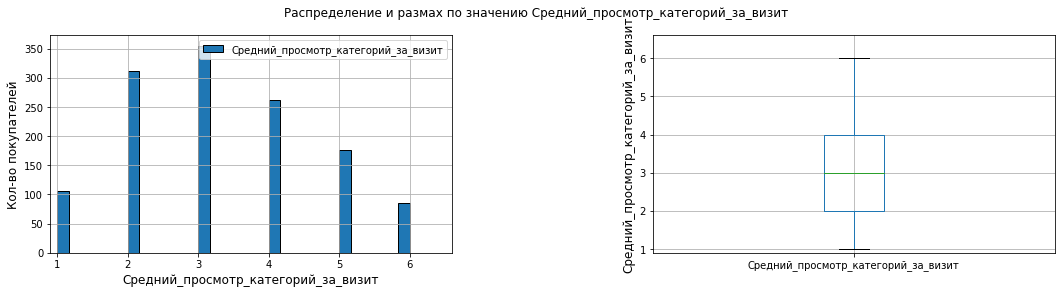

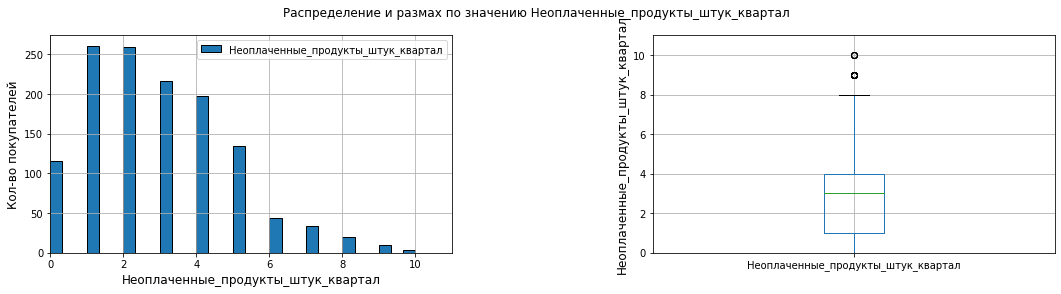

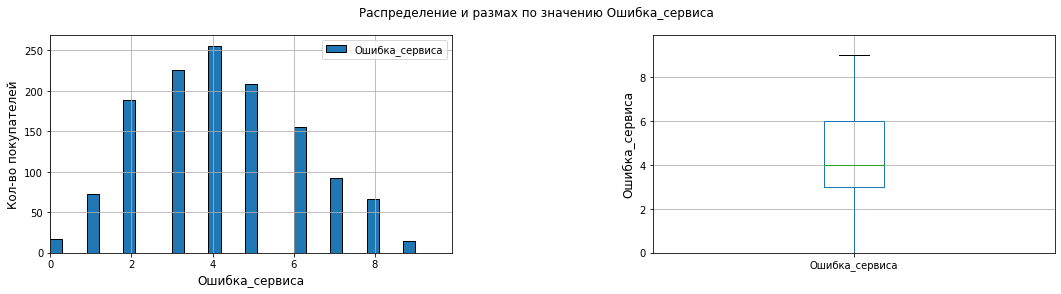

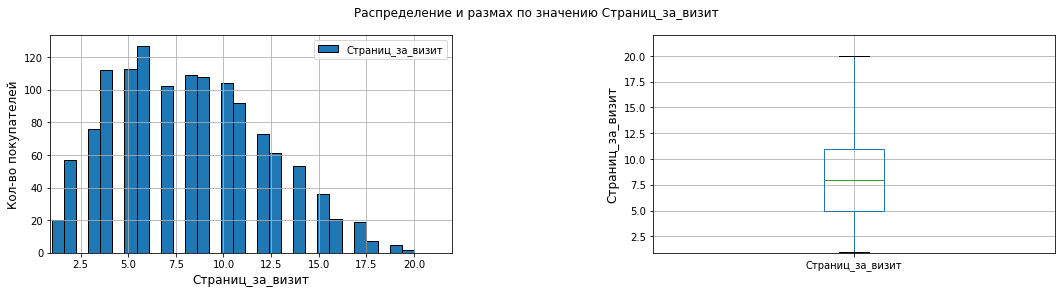

In [29]:
#выведем гистограмму распределения и диаграмму размаха(остальные 4 признака)
for column in  market_file.drop(['id'],axis=1).select_dtypes(include='number').columns.tolist()[4:]:
    hist_box(market_file.drop(['id'],axis=1).select_dtypes(include='number'),column)

 - Средний_просмотр_категорий_за_визит: значения в интервале от 1 до 6,распределение напоминает нормальное,
 - Неоплаченные_продукты_штук_квартал:значения свыше 8 являются редкими, наиболее частые значение 1-2,
 - Ошибка_сервиса: распределение наиболее близко к нормальному,
 - Страниц_за_визит: распределение также напоминает нормальное.

In [30]:
#фукнция для построения диаграммы размаха в разрезе покупательской активности
def boxplot (data,column):
    data.boxplot(column, by='Покупательская активность', figsize=(5,5))
    plt.ylabel(column, fontsize=12);
    plt.xlabel(' ', fontsize=12);
    plt.title('Диаграмма размаха по значению '+column);

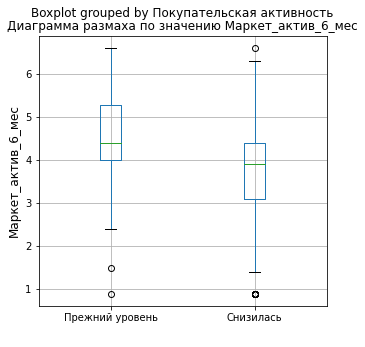

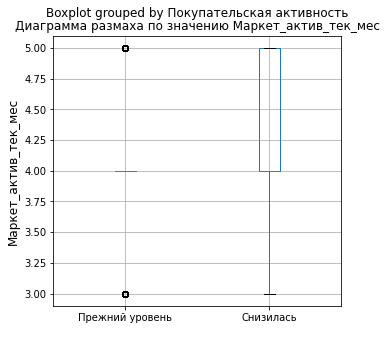

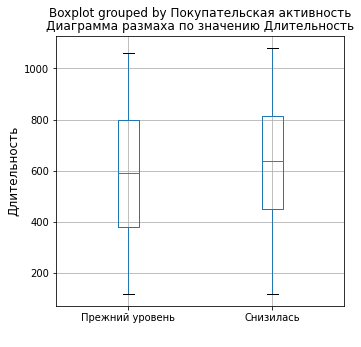

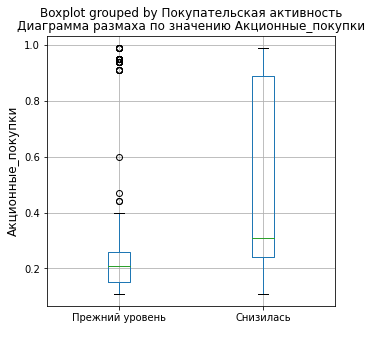

In [31]:
#выведем  диаграмму размаха в разрезе покупательской активности (первые 4 признака)
for column in  market_file.drop(['id'],axis=1).select_dtypes(include='number').columns.tolist()[:4]:
    boxplot(market_file,column)    

 Для покупателей со сниженной покупательской активностью по сравнению с покупателями с прежней:
 - Маркет_актив 6 мес: нижняя граница интервала ниже на 1, медиана также ниже примерно на 0.5, 50% между 1-м и 3-м квартилем находятся в более низком промежутке (примерно от 3 до 4.4) 
 - Маркет_актив_тек_мес: медиана совпадает - 4, при этом половина всех значение даже выше, чем у покупателей с прежней - от 4 до 5
 - Длительность:практически не отличается
 - Акционные_покупки:ярко прослеживается существенные различия. У покупателей с прежней активностью значения распределяются преимущественно в интервале до 0.4, медиана около 0.2,50% между 1-м и 3-м квартилем - от 0.1 до 0.25; со сниженной активностью - медиана близка к 0.3, при этом значения распределяются в интервале до 1,50% между 1-м и 3-м квартилем - от 0.25 до 0.9.

далее остальные признаки

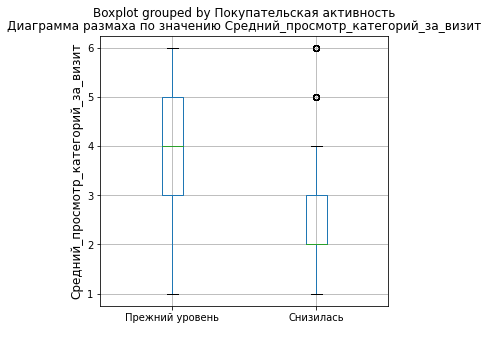

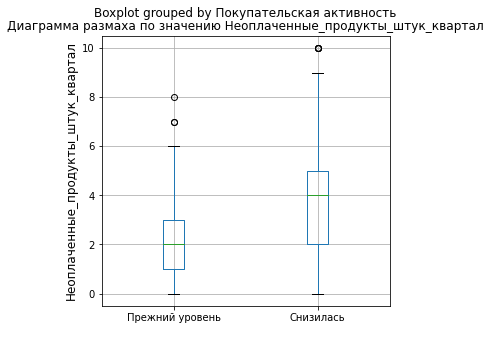

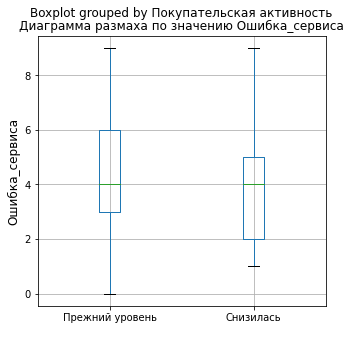

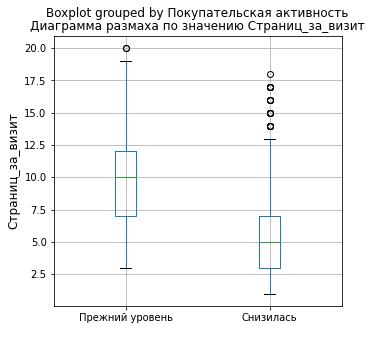

In [32]:
#выведем  диаграмму размаха в разрезе покупательской активности (остальные 4 признака)
for column in  market_file.drop(['id'],axis=1).select_dtypes(include='number').columns.tolist()[4:]:
    boxplot(market_file,column) 

 - Средний_просмотр_категорий_за_визит: также прослеживается существенная разница.Со сниженной активностью значения преимущественно в интервале от 1 до 4, с прежней - от 1 до 6
 - Неоплаченные_продукты_штук_квартал:со сниженной покупательской активностью значения в интервале от 0 до 9, причем 50% между 1-м и 3-м квартилем - от 2 до 5; с прежней - значения в интервале от 0 до 6, причем 50% между 1-м и 3-м квартилем - от 1 до 3
 - Ошибка_сервиса: распределение немного отличается,но в целом у 50% между 1-м и 3-м квартилем значение даже ниже - от 2 до 5, в то время как у с прежним уровнем от 3 до 6, медиана на одном уровне для обоих типов покупательской активности
 - Страниц_за_визит: в целом интервал распределения значений ниже, чем для прежней активности,  1-3 квартиль всех покупателей со сниженной активностью просматривают не более 7 страниц, в то время как с прежней только 1-й квартил просматривает до 7 страниц, остальные больше.

### Данные о выручке



Проанализируем данные файла с выручкой. Поскольку, кроме id, в файле есть данные по выручке каждого покупателя за каждый из 3-х последних месяцев в разрезе месяцев, то можно оценить как общее распределение выручки за каждые из 3-х месяцев в целом, так и в разрезе каждого покупателя. Выводить распределение данных по периоду (текущий, предыдущий и препередыдущий) нет смысла, т.к. само собой разумеется, что оно будет одинаковое - для каждого по 33.33%

In [33]:
market_money = market_money.query('id not in[215348, 215357, 215359]')
market_money.drop(['id'],axis=1).describe().T

,count,mean,std,min,25%,50%,75%,max
Выручка,"3,891.00","5,033.72","1,768.47","2,758.70","4,592.00","4,959.00","5,363.20","106,862.20"


Значение в интервале от 2,758.70 до 106,862.20, медиана чуть меньше среднего - возможно из-за выбросов в максимальных значениях выручки: до 75% всех значений до 5363, при этом максимальное значение в 20 раз больше. Оценим, сколько таких выбивающихся значений

In [34]:
market_money.sort_values(by='Выручка',ascending=False).head(10)

,id,Период,Выручка
98,215380,текущий_месяц,"106,862.20"
435,215493,текущий_месяц,"7,799.40"
262,215435,текущий_месяц,"7,605.30"
1481,215841,текущий_месяц,"7,557.00"
2388,216144,текущий_месяц,"7,547.80"
566,215536,текущий_месяц,"7,467.90"
2266,216103,текущий_месяц,"7,410.00"
1632,215892,текущий_месяц,"7,401.60"
1003,215682,текущий_месяц,"7,401.60"
1573,215872,текущий_месяц,"7,374.00"


Выбивающееся значение выручки только 1, является скорее аномалией, чем выбросом. Не будем учитывать данное аномальное значение далее

Далее построим гистограмму распределения значений выручки за каждый из  3-х месяцев

In [35]:
#перезапищем таблицу без учета аномального значения выручки
market_money = market_money.query('Выручка<7800')
a=['текущий_месяц','предыдущий_месяц','препредыдущий_месяц']

In [36]:
#создадим функцию для построения графика распределения 
def hist(data, label):
    data.hist(label=label,linewidth=5, alpha=0.7)

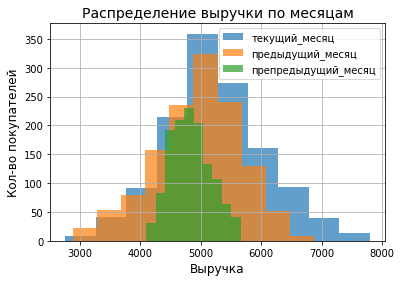

In [37]:
#создадим цикл для построения графика для каждого месяца из списка а
for i in a:
    hist(market_money.query('Период==@i')['Выручка'],label=i)

plt.legend()
plt.grid(True)
plt.ylabel('Кол-во покупателей', fontsize=12)
plt.xlabel('Выручка', fontsize=12)
plt.title('Распределение выручки по месяцам', fontsize=14)
plt.show()

Значение выручки, а также возможный интервал выручки увеличивается из месяца в месяц. Рассмотрим также диаграмму размаха

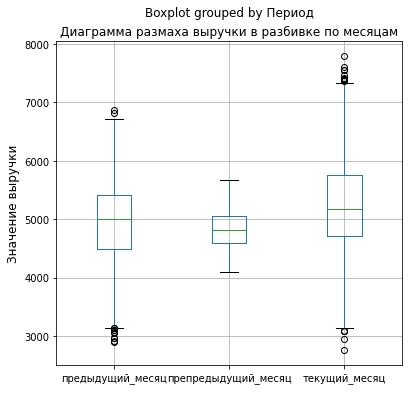

In [38]:
market_money.boxplot('Выручка', by='Период', figsize=(6,6))
plt.ylabel('Значение выручки', fontsize=12);
plt.xlabel(' ', fontsize=12);
plt.title('Диаграмма размаха выручки в разбивке по месяцам');

Это же подтверждается диаграммой размаха.

Проанализируем совокупную выручку в разрезе клиентов и по месяцам в целом

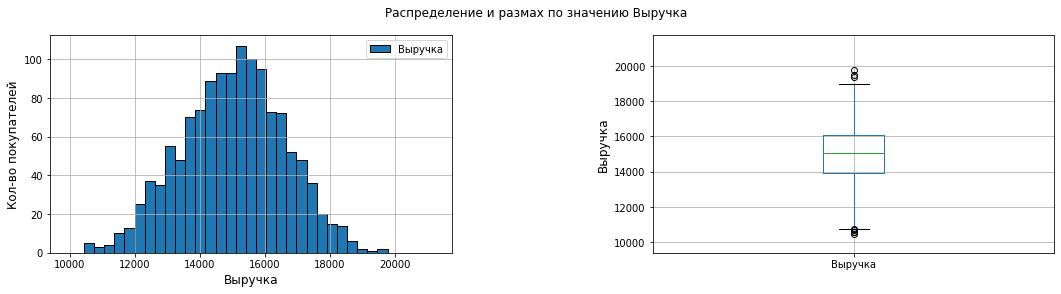

In [39]:
#распределение и размах по значению выручка в разрезе клиентов
hist_box(market_money.groupby('id').sum(),'Выручка')

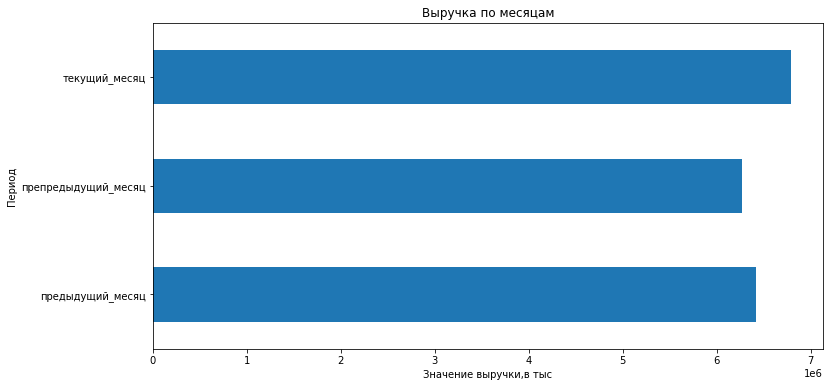

In [40]:
#выручка по месяцам
market_money.groupby('Период')['Выручка'].sum().plot(x ='Период',y='Выручка',\
          kind='barh', figsize=(12, 6));
plt.xlabel('Значение выручки,в тыс')
plt.title('Выручка по месяцам');

Распределение выручки в разрезе клиентов является нормальным, есть некоторые выбросы (редкие значения). В разрезе месяцев мы видим, что по всем клиентам в целом выручка имеет тенденцию к росту (значение за предыдущий месяц больше, чем за препредыдущий, за текущий больше, чем за предыдущий).

### Данные о времени

In [41]:
market_time = market_time.query('id not in[215348, 215357, 215359]')
market_time.drop(['id'],axis=1).describe().T

,count,mean,std,min,25%,50%,75%,max
минут,"2,594.00",13.34,4.08,4.00,10.00,13.00,16.00,23.00


Значения в интервале от 4 до 23 минут, медиана близка к среднему (13 и 13.34 соответственно)

Оценим распределение данных и размах о времени в разрезе покупателей за каждый период 

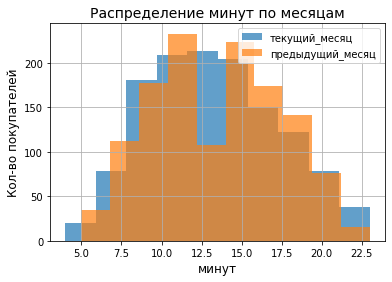

In [42]:
a=['текущий_месяц','предыдущий_месяц']

#создадим цикл для построения графика для каждого периода из списка а
for i in a:
    hist(market_time.query('Период==@i')['минут'],label=i)

plt.legend()
plt.grid(True)
plt.ylabel('Кол-во покупателей', fontsize=12)
plt.xlabel('минут', fontsize=12)
plt.title('Распределение минут по месяцам', fontsize=14)
plt.show()

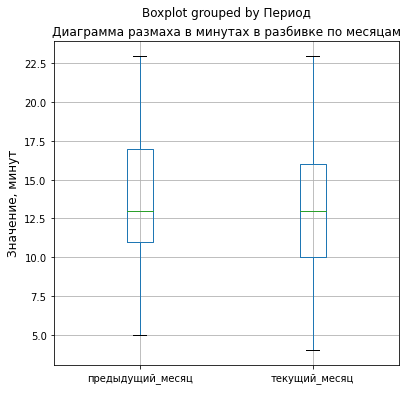

In [43]:
market_time.boxplot('минут', by='Период', figsize=(6,6))
plt.ylabel('Значение, минут', fontsize=12);
plt.xlabel(' ', fontsize=12);
plt.title('Диаграмма размаха в минутах в разбивке по месяцам');

Распределение в минутах в целом одинаковое, только в текущем месяце есть более низкие значения. Медиана находится примерно в одном значении ( около 13 минут).

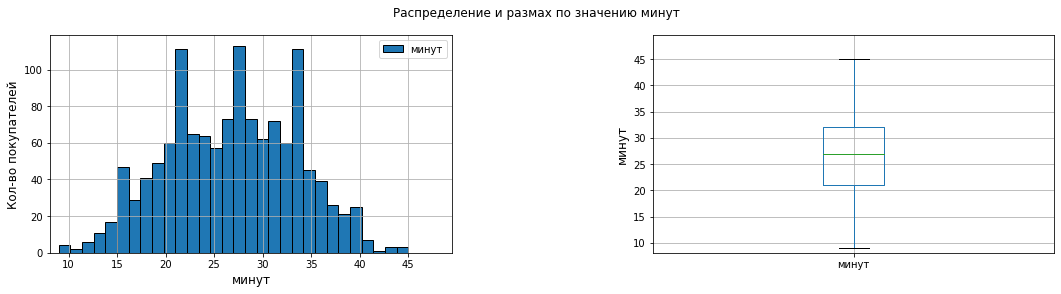

In [44]:
hist_box(market_time.groupby('id').sum(),'минут')

Присутствуют 3 наиболее частых значения - 22, 27 и 34 минуты, выбросы отсутствуют.

Оценим среднее время на пользователя за предыдущий и текущий месяца

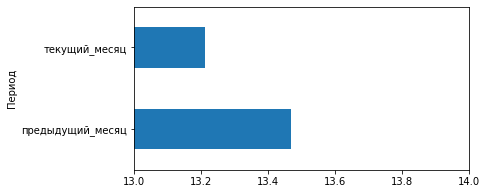

In [45]:
(market_time.groupby('Период')['минут'].sum()/market_time.groupby('Период')['минут'].count())\
         .plot(x ='Период',y='минут',kind='barh', figsize=(6, 3));
plt.xlim(13,14);

Среднее время, приходящееся на 1-го пользователя,несущественно сократилось с 13.46 минут до 13.2 минут

### Данные о прибыли

In [46]:
money = money.query('id not in[215348, 215357, 215359]')
money.drop(['id'],axis=1).describe().T

,count,mean,std,min,25%,50%,75%,max
Прибыль,"1,297.00",4.00,1.01,0.86,3.30,4.04,4.67,7.43


Данные в интервале от 0.86 у.е. до 7.43 у.е., медиана близка к среднему - 4 у.е.

Построим гистограмму распределения

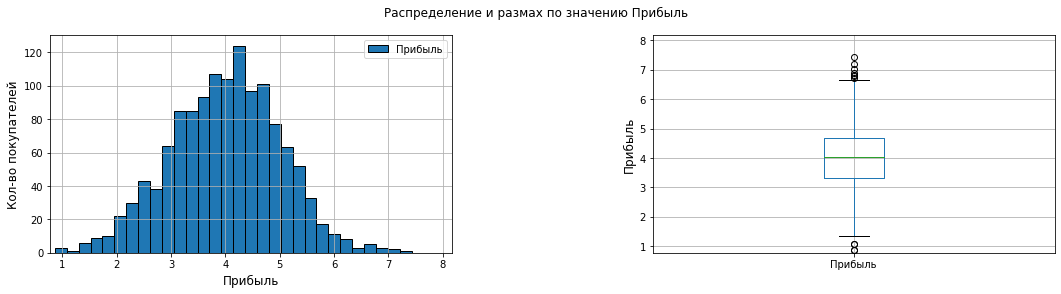

In [47]:
hist_box(money,'Прибыль')

Распределение является нормальным, есть редкие значение  - менее 1.3 и свыше 6.7.

### Вывод по исследовательскому анализу

1)Статистические характеристики в целом по всей выборке следующие:
- Категориальные данные в файле о покупателях несбалансированы: например, тип сервиса (стандарт - 71%, премиум 29%), согласие на рассылку дополнительных предложений о товаре (дало 74%, не дало - 26%),
- Количественные данные о покупателях: 
  - Маркет_актив6мес: среднее значение 4.25 в целом близко к медианному - 4.2,минимальное - 0.9, значения лежат в интервале от 0.9 до 6.6 коммуникаций в среднем,
  - Маркет_актив_тек_мес: значение коммуникаций за текущий месяц отличаются от средних за 6 последних - минимальные значения выросли до 3-х, но максимальные снизились до 5.
  - Длительность:с момента регистрации покупателя на сайте прошло от 121 до 1079 дней, среднее значение и медиана близки - 603 и 607 соответственно,
  - Акционные_покупки: доля составляет от 11% до 99%, при этом среднее значение выше медианы - 32% и 24% соответственно,
  - Средний_просмотр_категорий_за_визит: значения в интервале от 1 до 6, среднее значение и медиана близки - 3.27 и 3 соответственно,
  - Неоплаченные_продукты_штук_квартал:значения в интервале от 0 до 10, среднее и медиана близки - 2.84 и 3 соответственно,
  - Ошибка_сервиса: значение в интервале от 0 до 9,среднее и медиана близки - 4.18 и 4 соответственно,
  - Страниц_за_визит: значение в интервале от 1 до 20,среднее и медиана близки - 8.19 и 8 соответственно.
- Выручка и медианное значение увеличивается из месяца в месяц, также увеличивается возможный интервал выручки. Исключено 1 аномальное значение выручки (более чем в 10 раз превышает следующее по уровню значение), 
- Время на сайте: распределение в минутах в предыдущем и текущем месяцах в целом одинаковое, только в текущем месяце есть более низкие значения. Медиана находится примерно в одном значении ( около 13 минут). Среднее время, приходящееся на 1-го пользователя,несущественно сократилось (с 13.46 минут до 13.2 минут)
- Прибыль: данные в интервале от 0.86 у.е. до 7.43 у.е., медиана близка к среднему - 4 у.е.Распределение является нормальным, есть редкие значение - менее 1.3 и свыше 6.7.

2)Стоит также отдельно описать статистические характеристики покупателей со сниженной покупательской активностью по сравнению с покупателями с прежней покупательской активностью:
- Популярная категория: выше доля товаров типа Мелкая бытовая техника и электроника, Товаров для детей и доля Домашнего текстиля - совокупная доля по данным категориям почти 71%, у покупателей с прежней активностью - 56%, доля Кухонной посуды более чем в 3 раза меньше, чем у покупателей с прежней акивностью.
- Маркет_актив 6 мес: значение в интервале до 2.4 встречаются практически только у покупателей со сниженной покуп актив-ю, медиана значени ниже примерно на 0.5, 50% между 1-м и 3-м квартилем находятся в более низком промежутке (примерно от 3 до 4.4). 
- Маркет_актив_тек_мес: распределение отличается от покупателей с прежней - половина всех значение даже выше, чем у покупателей с прежней - от 4 до 5.
- Акционные_покупки:ярко прослеживается существенные различия.Со сниженной активностью значения распределяются в интервале до 1 (с прежней преимущественно до 0.4), 50% между 1-м и 3-м квартилем - от 0.25 до 0.9. 
- Средний_просмотр_категорий_за_визит: также прослеживается существенная разница.Со сниженной активностью значения преимущественно в интервале от 1 до 4, если выше 4-х - это преимущественно покупатели с прежней активностью.
- Неоплаченные_продукты_штук_квартал:со сниженной покупательской активностью значения в интервале от 0 до 9, причем 50% между 1-м и 3-м квартилем - от 2 до 5; с прежней - значения в интервале от 0 до 6, причем 50% между 1-м и 3-м квартилем - от 1 до 3. Т.о. если товаров в корзине свыше 6, то это скорее всего покупатели со сниженной активностью.
- Страниц_за_визит: в целом интервал распределения значений ниже, чем для прежней активности,75%(1-3 квартиль всех покупателей)просматривают не более 7 страниц, в то время как с прежней только 1-й квартиль просматривает до 7 страниц, остальные больше.В целом просмотр страниц превышает не более 13.
- характеристики по выручке, времени на сайте и прибыли опишем далее после объединения таблиц. 


## Объединение таблиц

Объединим таблицы market_file.csv, market_money.csv, market_time.csv. Данные о выручке и времени на сайте находятся в одном столбце для всех периодов, поэтому в итоговой таблице будут отдельные столбцы для каждого периода.

Сначала подготовим данные таблиц о выручке и времени перед объединением.

In [48]:
market_money_1 = market_money.pivot_table(index='id',columns='Период',values='Выручка')
market_money_1.head()

Период,предыдущий_месяц,препредыдущий_месяц,текущий_месяц
id,,,
215349,"5,216.00","4,472.00","4,971.60"
215350,"5,457.50","4,826.00","5,058.40"
215351,"6,158.00","4,793.00","6,610.40"
215352,"5,807.50","4,594.00","5,872.50"
215353,"4,738.50","5,124.00","5,388.50"


Аналогичные манипуляции проведем с файлом о времени

In [49]:
market_time_1 = market_time.pivot_table(index='id',columns='Период',values='минут')
market_time_1.head()

Период,предыдущий_месяц,текущий_месяц
id,,
215349,12,10
215350,8,13
215351,11,13
215352,8,11
215353,10,10


Поскольку в разных столбцах новых таблиц о выручке и времени разная информация, но называются они одинаково - переименуем столбцы 

In [50]:
#переименуем столбцы в данных о выручке
market_money_1 = market_money_1.rename(
    columns={'препредыдущий_месяц':'препред_мес_выручка','предыдущий_месяц':'пред_месяц_выручка',\
             'текущий_месяц':'тек_месяц_выручка'}
)
#переименуем столбцы в данных о времени
market_time_1 = market_time_1.rename(
    columns={'предыдущий_месяц':'пред_месяц_минут','текущий_месяц':'тек_месяц_минут'}
)
#выведем названия столбцов для файла о выручке
market_money_1.columns

Index(['пред_месяц_выручка', 'препред_мес_выручка', 'тек_месяц_выручка'], dtype='object', name='Период')

Далее объединим таблицы

In [51]:
#перенесем id покупателей в индексы, поскольку в других таблицах они в индексах и для анализа далее не нужны
market = market_file.set_index('id')
#объедним сразу 3 таблицы
market = market.join([market_money_1,market_time_1],how='inner')
#выведем объединенную таблицу
market.sample(5)

,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,пред_месяц_выручка,препред_мес_выручка,тек_месяц_выручка,пред_месяц_минут,тек_месяц_минут
id,,,,,,,,,,,,,,,,,
215868,Прежний уровень,стандарт,да,4.90,5,851,0.11,Косметика и аксесуары,3,0,4,9,"5,149.50","5,265.00","5,179.40",17,16
216515,Прежний уровень,стандарт,да,4.90,4,882,0.17,Косметика и аксесуары,3,2,6,9,"5,007.00","4,761.00","5,350.20",16,19
216505,Прежний уровень,стандарт,нет,5.90,4,617,0.16,Мелкая бытовая техника и электроника,2,3,5,10,"5,998.50","5,595.00","6,478.20",21,18
215894,Снизилась,стандарт,да,3.60,4,785,0.30,Мелкая бытовая техника и электроника,2,1,3,11,"6,149.00","5,236.00","5,487.30",18,22
215709,Снизилась,стандарт,нет,4.60,5,352,0.89,Домашний текстиль,1,3,2,6,"5,221.50","4,755.00","5,606.30",12,10


In [52]:
#проверим размер
market = market.dropna(axis=0)
market.shape

(1296, 17)

Дополнительно проанализируем размах значений данных о выручке и времени на сайте в разрезе покупательской активности

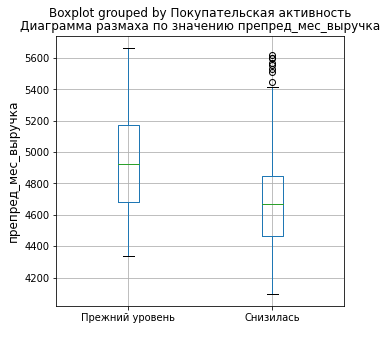

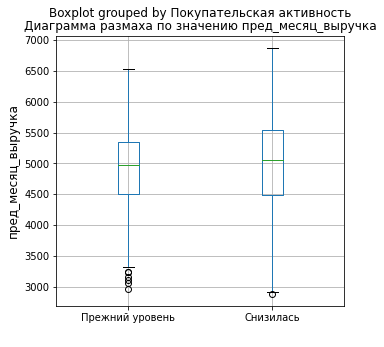

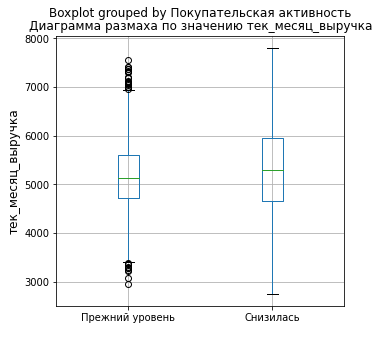

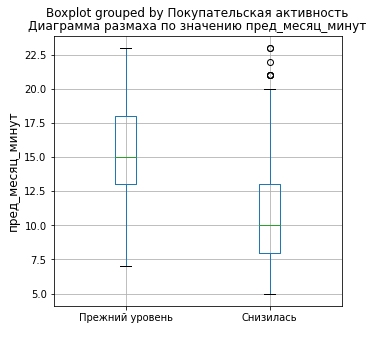

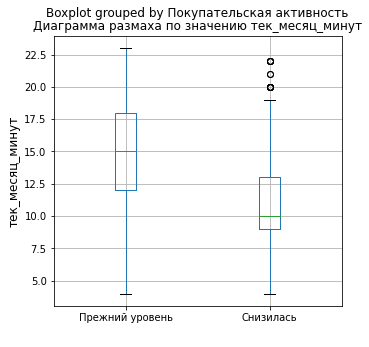

In [53]:
#зададим список из новых столбцов
columns= ['препред_мес_выручка','пред_месяц_выручка','тек_месяц_выручка','пред_месяц_минут','тек_месяц_минут']
#выведем боксплоты через цикл
for column in  columns:
    boxplot(market,column)

**Вывод после объединения**:

Таблицы объединены, итогом являются данные о 1296 покупателях и 17-ю признаками.

Также в разрезе выручки и времени, проведенном на сайте, у покупателей со сниженной покупательской активностью следующие характеристики:
- интервал выручки в препредыдущем месяце в целом ниже, если значение выручки ниже 4340 - это точно покупатель со сниженной активностью,
- интервал выручки за предыдущий и текущий месяца даже шире, чем для прежней активности, медианы практически не отличаются,
- время на сайте за предыдущий месяц: в среднем меньше проводили время, значение менее 7 минут - точно покупатель со сниженной активностью, выше 20 минут - скорее всего с прежней,
- время на сайте за текущий месяц:в среднем меньше проводят время,преимущественно не более 18 минут, медиана на 5 минут ниже, чем у прежней активности, 75% проводят не более 13 минут, 25% - от 13 до 18.

## Корреляционный анализ

### Матрицы корреляции

Посчитаем коэффициент корреляции Фи, который находит взаимосвязь между категориальными, порядковыми и интервальными признаками.

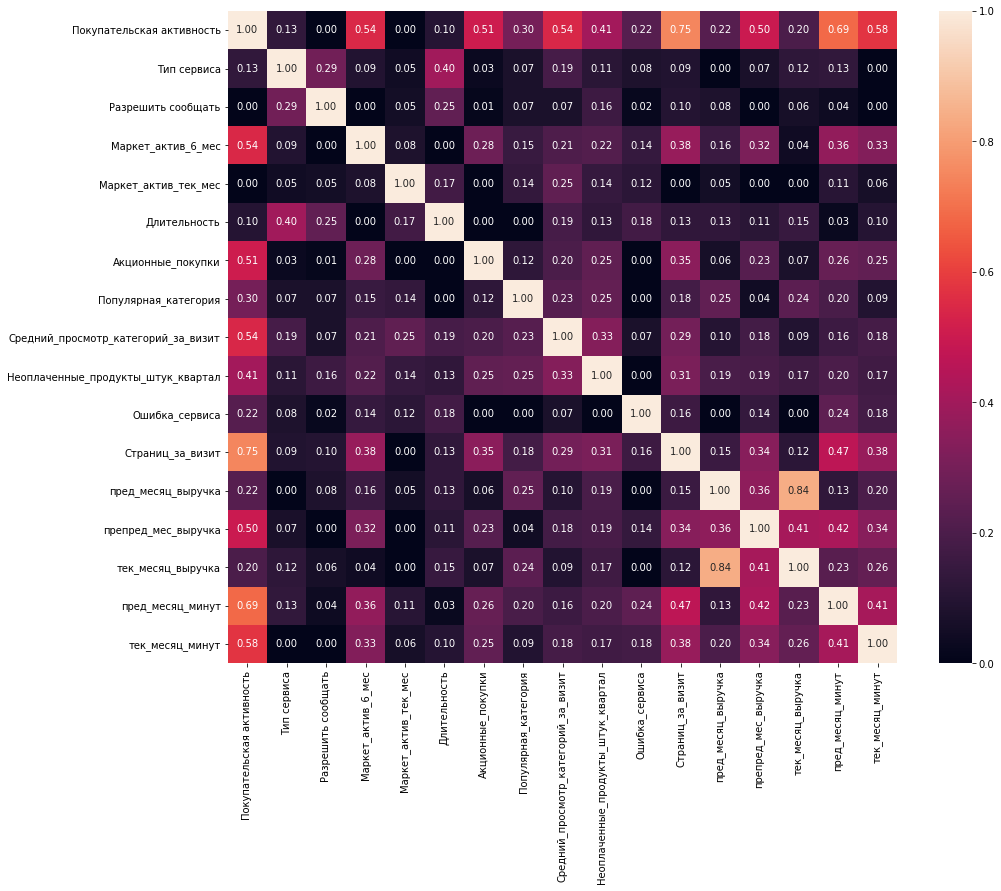

In [54]:
#построим матрицу корреляции
fig, ax = plt.subplots(figsize=(15, 12));
sns.heatmap(market.phik_matrix(
    interval_cols = [
        'Маркет_актив_6_мес', 'Длительность', 'Акционные_покупки', 'пред_месяц_выручка', 'препред_мес_выручка',\
        'тек_месяц_выручка', 'пред_месяц_минут', 'тек_месяц_минут'
    ]
),ax=ax, annot=True, fmt='.2f');

Максимальные значения корреляции покупательской активности со следующими признаками: 
 - далее покупательская активность и страниц за визит (0.75), 
 - покупательская активность и время, проведенное на сайте - в предыдущем месяце (0.69) и в текущем месяце(0.58) 
 - покупательская активность и средний просмотр за визит (0.54),
 - покупательская активность и акционные покупки,
 - корреляция прочих признаков не более 0.5.

Такж высокая корреляция выручек текущего и предыдущего месяцев (0.84) 

Также построим тепловую матрицу для оценки корреляции количественных признаков методом Спирмена

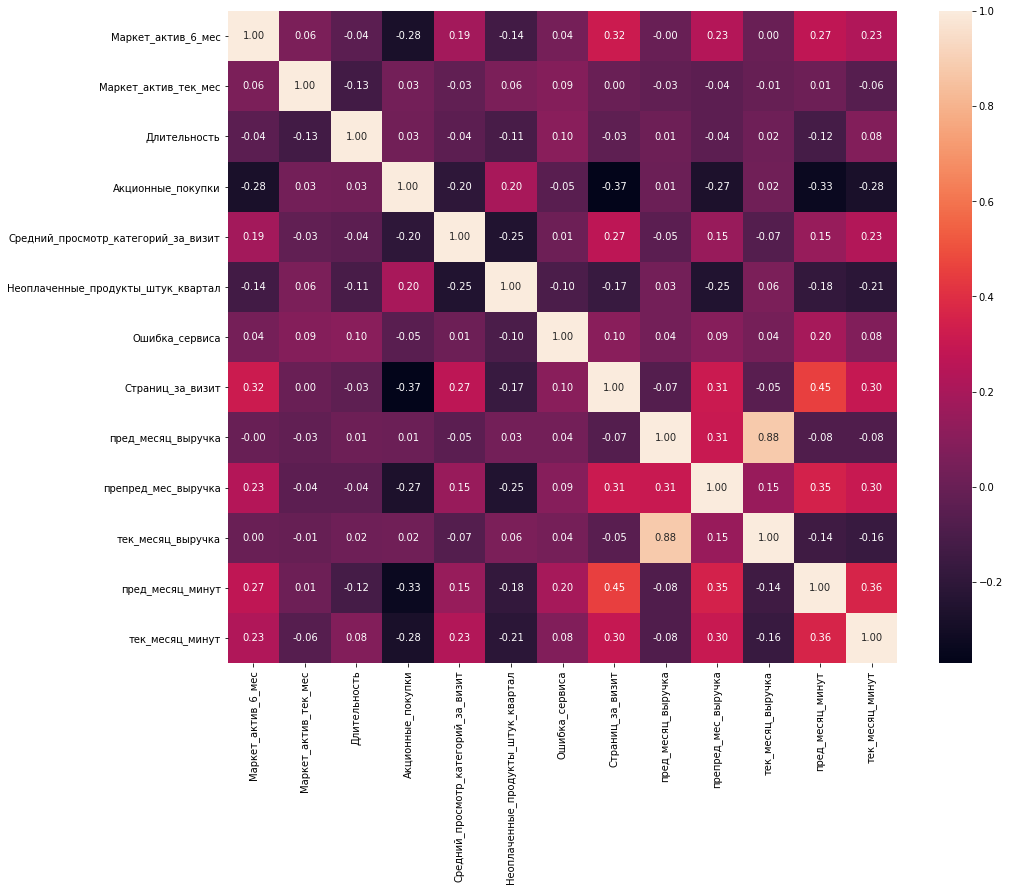

In [55]:
#построим матрицу корреляции
fig, ax = plt.subplots(figsize=(15, 12));
sns.heatmap(market.corr(method='spearman'),ax=ax, annot=True, fmt='.2f');

Мультиколлинеарность ( значение свыше или равно 0.9) при анализе только количественных признаков также не выявлена: максимальный коэф-т между показателями выручек за предыдущий и текущий месяца - 0.88, между остальными признаками значения корреляции существенно ниже

### Распределение признаков с учетом покупательской способности

Рассмотрим парные матрицы диаграмм рассеивания  для  количественных признаков между собой в разбивке по типу покупательской активности.

In [56]:
#вынесем в отдельный список столбцы с количественными признаками и  добавим туда столбец с покупательской актив-ю
columns_pair = market.select_dtypes(include='number').columns.tolist()
columns_pair

['Маркет_актив_6_мес',
 'Маркет_актив_тек_мес',
 'Длительность',
 'Акционные_покупки',
 'Средний_просмотр_категорий_за_визит',
 'Неоплаченные_продукты_штук_квартал',
 'Ошибка_сервиса',
 'Страниц_за_визит',
 'пред_месяц_выручка',
 'препред_мес_выручка',
 'тек_месяц_выручка',
 'пред_месяц_минут',
 'тек_месяц_минут']

У нас 13 количественных признаков. При выводе парных графиков для всех 13 признаков на одном графике одновременно оценить что-то визуально будет сложно, поэтому будет выводить по несколько парных графиков на одном

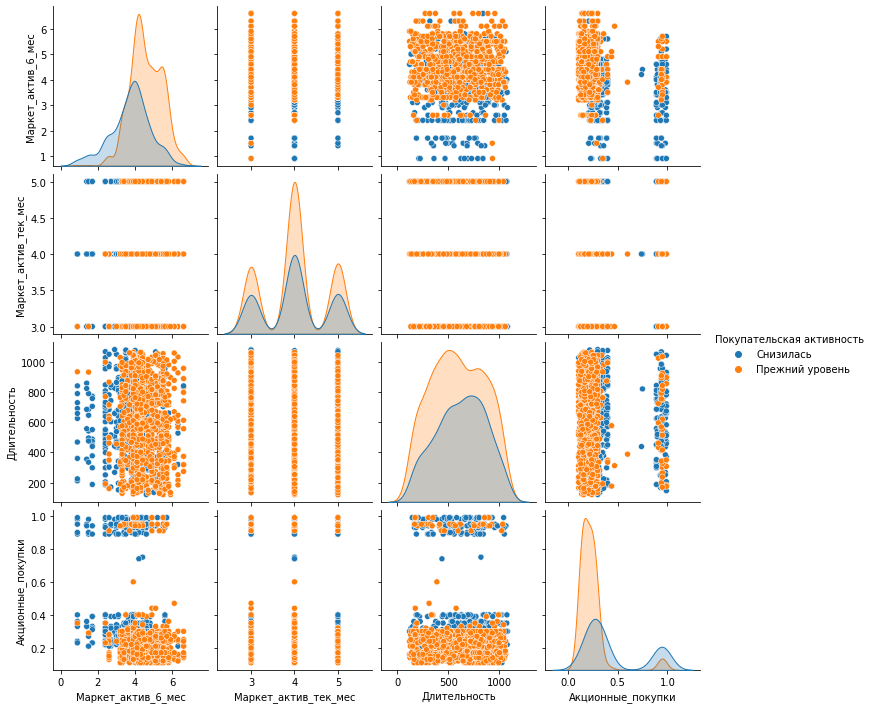

In [57]:
#выведем матрицу парных графиков для первых 4-х признаков с подсветкой покупательской активности
pair_1 = [*columns_pair[:4],'Покупательская активность']
sns.pairplot(market[pair_1],hue = 'Покупательская активность')
plt.show()

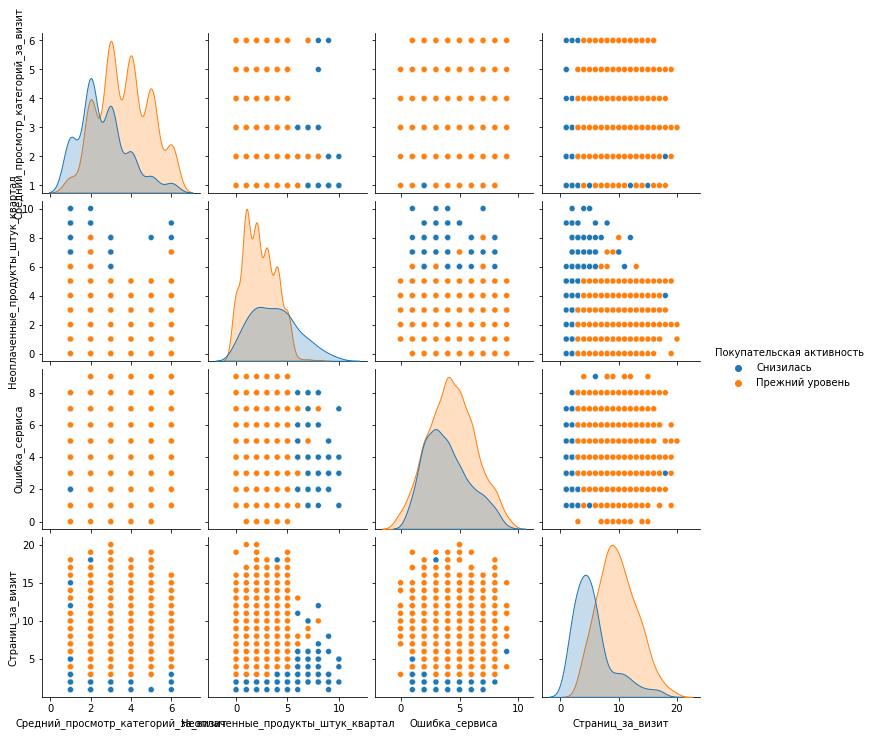

In [58]:
#выведем матрицу парных графиков для следующих 4-х признаков с подсветкой покупательской активности
pair_2 = [*columns_pair[4:8],'Покупательская активность']
sns.pairplot(market[pair_2],hue = 'Покупательская активность')
plt.show()

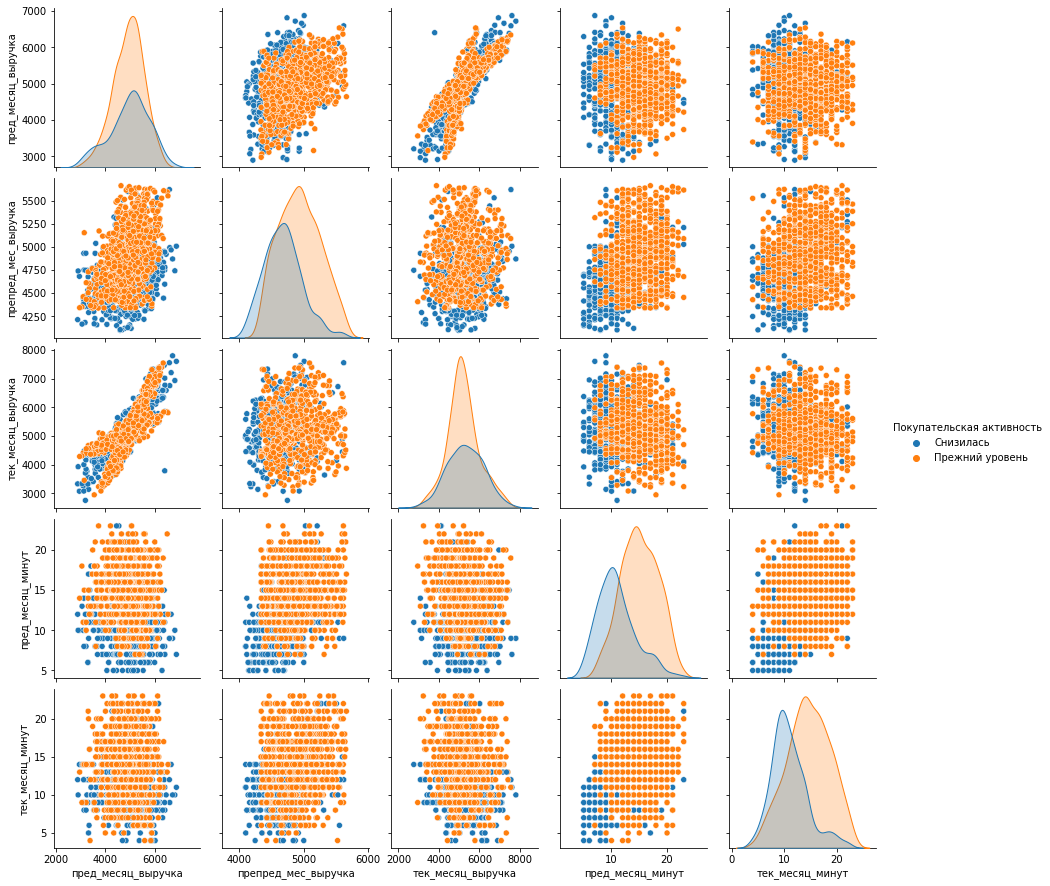

In [59]:
#выведем матрицу парных графиков для оставшихся 5-ти признаков с подсветкой покупательской активности
pair_3 = [*columns_pair[8:],'Покупательская активность']
sns.pairplot(market[pair_3],hue = 'Покупательская активность')
plt.show()

В целом прослеживаются следующие зависимости:
 - Маркет_актив_6_мес: сниженной покупательской активности соответствуют более низкие средние значения маркетинговой активности за 6 мес,если значение 2 или меньше - это будет сниженная покуп активность, от 2 до 3-х - преимущественно сниженная,
 - Маркет_актив_тек_мес: одинаково для любого типа покупа актив-ти,
 - Длительность: свыше 800 - только прежний уровень покуп актив-ти,
 - Акционные_покупки: прежнему уровню соответствует меньшая доля акционных покупок (до 0.4), в то время как для сниженной - преобладает доля свыше 0.4.
 - Средний_просмотр_категорий_за_визит: сниженной соответствует более низкие значения категорий, чем для прежней,
 - Неоплаченные_продукты_штук_квартал: для сниженной активности значение не превышает 4, в то время как для прежней весь разброс возможных значений, т.е. все свыше 4 - точно 
 - Ошибка_сервиса: одинаково,
 - Страниц_за_визит: свыше 10 страниц - преимущественно прежняя активность, до 7 страниц - преимущественно сниженная,
 - пред_месяц_выручка, препред_мес_выручка, тек_месяц_выручка:ожидаемо низким значениям соответствует сниженная активность, выручка за предыдущий месяц и текущий месяц высоко коррелируют между собой - стоит попробовать исключить один из этих признаков (например, за предыдущий месяц) и оценить показатели модели без нее 
 - пред_месяц_минут, тек_месяц_минут:свыше 12-13 минут - преимущественно прежний уровень.


### Вывод по корреляционному анализу

**Вывод по корреляционному анализу**:

Согласно коэф-та Фи, больше всего покупательская активность коррелирует с кол-вом страниц за визит (0.75), временем, проведенном на сайте - в предыдущем месяце (0.69) и в текущем месяце(0.58),средним просмотром страниц за визит (0.54) и  акционными покупками. Согласно коэф-та Спирмена присутствуют 2 признака с очень высокой корреляцией - выручка за текущий и предыдущий месяца (значение коэф-та 0.88), мультиколлинеарность (значение свыше 0.9) отсутствует.

Прослеживаются следующие зависимости покупательской активности с количественными признаками:
 - Маркет_актив_6_мес: сниженной покупательской активности соответствуют более низкие средние значения маркетинговой активности за 6 мес,если значение 2 или меньше - это будет сниженная покуп активность, от 2 до 3-х - преимущественно сниженная,
 - Длительность: свыше 800 - только прежний уровень покуп актив-ти,
 - Акционные_покупки: прежнему уровню соответствует меньшая доля акционных покупок (до 0.4), в то время как для сниженной - преобладает доля свыше 0.4.
 - Средний_просмотр_категорий_за_визит: сниженной соответствует более низкие значения категорий, чем для прежней,
 - Неоплаченные_продукты_штук_квартал: для сниженной активности значение не превышает 4, в то время как для прежней весь разброс возможных значений, т.е. все свыше 4 - точно 
 - Страниц_за_визит: свыше 10 страниц - преимущественно прежняя активность, до 7 страниц - преимущественно сниженная,
 - пред_месяц_выручка, препред_мес_выручка, тек_месяц_выручка:ожидаемо низким значениям соответствует сниженная активность, выручка за предыдущий месяц и текущий месяц высоко коррелируют между собой - стоит попробовать исключить один из этих признаков (например, за предыдущий месяц) и оценить показатели модели без нее 
 - пред_месяц_минут, тек_месяц_минут:свыше 12-13 минут - преимущественно прежний уровень.

## Использование пайплайнов

Применим разные модели. Для этого используем пайплайны.
 - Во время подготовки данных используйем ColumnTransformer. Количественные и категориальные признаки обработаем в пайплайне раздельно. Для кодирования категориальных признаков используем 3 кодировщика, для масштабирования количественных — как минимум 2 скейлера.
 - Обучим четыре модели: KNeighborsClassifier(), DecisionTreeClassifier(), LogisticRegression() и  SVC(). Для каждой из них подберем гиперпараметры. Выберем и аргументируем подходящую для задачи метрику и  используем эту метрику при подборе гиперпараметров.
 - Выберем лучшую модель, используя заданную метрику. Для этого применим 2 стратегии:
   - использем один общий пайплайн для всех моделей и инструмент подбора гиперпараметров - RandomizedSearchCV , который вернёт нам лучшую модель.
   - использем пайплайны и инструменты подбора гиперпараметров для каждой модели отдельно, чтобы выбрать лучшую модель самостоятельно.


### Общий пайплайн

Выделим целевой признак и прочие, произведем разбивку на тренинговую и тестовую выборку. В данных есть дисбаланс классов, поэтому обязательно выполним стратификацию по целевому признаку.

In [60]:
#выделим целевой признак и прочие, исключим признак выручка за предыд месяц
#добавим преобразованный в категориал бинальный признак доля акционных покупок
y = market['Покупательская активность'].apply(lambda x: 1 if x=='Снизилась' else 0)

X = market.drop(['Покупательская активность'], axis=1)

X.head(1)

,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,пред_месяц_выручка,препред_мес_выручка,тек_месяц_выручка,пред_месяц_минут,тек_месяц_минут
id,,,,,,,,,,,,,,,,
215349,премиум,да,4.40,4,819,0.75,Товары для детей,4,4,2,5,"5,216.00","4,472.00","4,971.60",12,10


In [61]:
# произведем разбивку на тренинговую и тестовую выборки, установим долю тестовой выборки и RANDOM_STATE
RANDOM_STATE = 42
TEST_SIZE = 0.25

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = y)

Пропуски отсутсвуют(то есть применять инструменты для их заполнения для кодирования не нужно), у нас 4 категориальных признака( в т.ч. целевой) и 12 количественных.
Требуется кодировать категориальные признаки, причем значений в Популярной категории больше 2-х, данный признак будем кодировать отдельно. Количественные признаки существенно отличаются в значениях, поэтому проведем их масштабирование

Выделим отдельно 2 типа категориальных признаков и количественные

In [62]:
ohe_columns = ['Тип сервиса', 'Разрешить сообщать']
ord_columns = ['Популярная_категория']
num_columns = X_train.select_dtypes(include='number').columns.tolist()

In [63]:
#предобработка данных
data_preprocessor = ColumnTransformer([
    ('ohe', OneHotEncoder(drop='first', handle_unknown='error'), ohe_columns),
    ('ord', OrdinalEncoder(), ord_columns),
    ('num', StandardScaler(), num_columns)
],
    remainder='passthrough')

Далее создадим итоговый пайплайн. Обучим четыре модели: KNeighborsClassifier(), DecisionTreeClassifier(), LogisticRegression() и  SVC(). Для каждой из них подберем  гиперпараметры.

Т.к. дисбаланс таргета есть, но он не существенный, то подходит метрика, учитывающая баланс полноты и точности(accuracy, f1 или ROC_AUC) при подборе гиперпараметров. Выберем ROC_AUC.

Сначала использем один общий пайплайн для всех моделей и инструмент подбора гиперпараметров (методом рандома), который вернёт лучшую модель.

In [64]:
# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))        
])

param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 10),
        'models__max_features': range(2, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(),RobustScaler(), 'passthrough']  
    },
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 50),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(),RobustScaler(), 'passthrough'] 
    },

    # словарь для модели LogisticRegression()
    {
         'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': (0,100), 
        'preprocessor__num': [StandardScaler(), MinMaxScaler(),RobustScaler(), 'passthrough'] 
    },
    # словарь для модели SVC()
    {
        'models': [SVC(probability=True)],
        'models__kernel': ['linear', 'rbf'],   
        'preprocessor__num': [StandardScaler(), MinMaxScaler(),RobustScaler(), 'passthrough'] 
    }
]

randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели при кросс-валидации:', randomized_search.best_score_)

y_test_pred = randomized_search.predict_proba(X_test)
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_pred[:,1])}')

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(drop='first'),
                                                  ['Тип сервиса',
                                                   'Разрешить сообщать']),
                                                 ('ord', OrdinalEncoder(),
                                                  ['Популярная_категория']),
                                                 ('num', StandardScaler(),
                                                  ['Маркет_актив_6_мес',
                                                   'Маркет_актив_тек_мес',
                                                   'Длительность',
                                                   'Акционные_покупки',
                                                   'Средний_просмотр_категорий_за_ви

В качестве лучшей модели выбрана модель k-ближайших соседей с k=49 и методом масштабирования StandardScaler: показатели метрики при кросс-валидации 0.901, на тестовой - 0.923.


## Анализ важности признаков

 - Оценим важность признаков для лучшей модели и построим график важности с помощью метода SHAP. 
 - Сделаем выводы о значимости признаков:
   - какие признаки мало значимы для модели;
   - какие признаки сильнее всего влияют на целевой признак;
   - как можно использовать эти наблюдения при моделировании и принятии бизнес-решений.

In [65]:
#предобработка данных 
preprocessor = randomized_search.best_estimator_.named_steps['preprocessor']
X_test_preprocessed = preprocessor.transform(X_test)

#Получаем имена признаков для ohe, остальные можем использовать как есть
ohe_names = preprocessor.named_transformers_['ohe'].get_feature_names_out(input_features=ohe_columns)

# Объединяем все имена признаков в один список(количественные и орд передаем как есть)
names = np.concatenate([ohe_names, ord_columns, num_columns])

#проверим все ли признаки переданы и в каком виде
names

array(['Тип сервиса_стандарт', 'Разрешить сообщать_нет',
       'Популярная_категория', 'Маркет_актив_6_мес',
       'Маркет_актив_тек_мес', 'Длительность', 'Акционные_покупки',
       'Средний_просмотр_категорий_за_визит',
       'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса',
       'Страниц_за_визит', 'пред_месяц_выручка', 'препред_мес_выручка',
       'тек_месяц_выручка', 'пред_месяц_минут', 'тек_месяц_минут'],
      dtype=object)

Мы видим названия всех столбцов после кодирования и масштабирования.

Оценим общую важность признаков модели с помощью столбчатой диаграммы Шепли.

  0%|          | 0/50 [00:00<?, ?it/s]

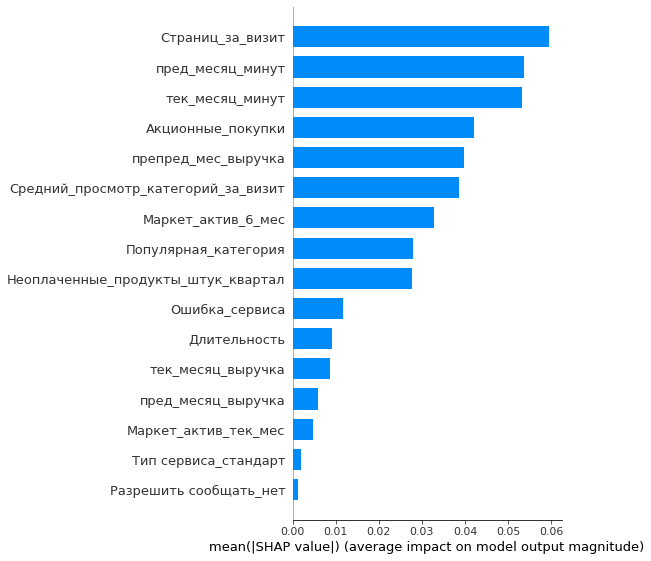

In [66]:
X_test_preprocessed = pd.DataFrame(X_test_preprocessed, columns=names)

#построим график важности с помощью метода SHAP, 
#тестовые признаки для ускорения обработки сократим сэмплом - выбираются любые 50 значений
explainer = shap.KernelExplainer(
    randomized_search.best_estimator_['models'].predict_proba,\
    shap.sample(X_test_preprocessed,50,random_state=RANDOM_STATE)
)
shap_values = explainer(shap.sample(X_test_preprocessed,50,random_state=RANDOM_STATE))

shap.summary_plot(shap_values[:,:,1],plot_type='bar',max_display=17)

Наиболее важными признаками являются:кол-во просмотренных страниц за визит, общее время, проведенное на сайте ( за текущий месяц и за предыдущий), популярная категория, выручка за препредыдущий месяц,акционные покупки,средняя маркетинговая активность за последние 6 мес,средний просмотр категорий за визит и кол-во неоплаченных продуктов в квартал.
 
Остальные признаки малозначимы (влияение менее 0.02), тип сервиса и разрешение сообщать о новых предложениях вообще несущественные признаки.

Также оценим вклад признаков в классификацию каждого наблюдения

  0%|          | 0/324 [00:00<?, ?it/s]

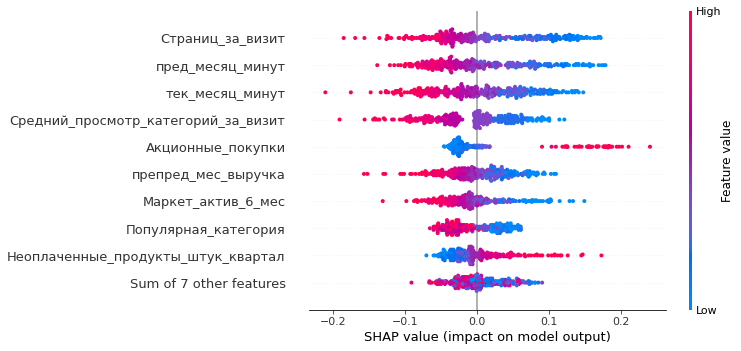

In [67]:
shap_values = explainer(X_test_preprocessed)
shap.plots.beeswarm(shap_values[:,:,1])

Чем выше величина признаков страниц за визит, проведенного временени,кол-ва просмотров категорий, выручки за препредыдущий месяц, маркетинговой активности за последние 6 месяцев,тем выше вероятность отнесения объектов к классу 0, т.е."прежней покупательской активности". Для акционных покупок и неоплаченных продуктов наоборот - чем выше значение признака, тем больше модель склоняется к тому, чтобы присвоить целевому признаку класс 1, т.е. что покупательская активность снизится.

**Вывод по анализу важности признаков**:

Наиболее важными признаками являются:кол-во просмотренных страниц за визит, общее время, проведенное на сайте (в первую очередь за текущий месяц, далее за предыдущий), кол-во просмотренных страниц за визит,популярная категория, выручка за препредыдущий месяц,акционные покупки,средняя маркетинговая активность за последние 6 мес,средний просмотр категорий за визит и кол-во неоплаченных продуктов в квартал. Остальные признака малозначимы (влияние менее 0.02).

Для предотвращения снижение покупательской активности, понимая какие признаки наиболее значимы, мы можем провести мероприятия, которые могут повлиять именно на эти признаки, и не тратить время на прочие, которые мало влияют на изменение уровня покупательской активности.

## Сегментация покупателей

1) Выполним сегментацию покупателей. Используем результаты моделирования и данные о прибыльности покупателей.

2) Выберем группу покупателей и предложим, как увеличить её покупательскую активность: 
 - Проведем графическое и аналитическое исследование группы покупателей.
 - Сделаем предложения по работе с сегментом для увеличения покупательской активности.

3) Сделаем выводы о сегментах:
 - какой сегмент взяли для дополнительного исследования,
 - какие предложения сделали и почему.
 

### Сегментация покупателей

Проанализируем клиентов с высокой вероятностью снижения покупательской активности и прибыльностью выше среднего

In [68]:
#сохраним нашу лучшую модель в переменную
model = randomized_search.best_estimator_

#выведем расчетное значение класса из  тестовой выборки
proba = model.predict_proba(X_test)[:,1]

#создадим таблицу из этих расчетных значений
custom = pd.DataFrame(zip(proba), columns = ['proba'])

#посмотрим как выглядит таблица
custom.sample(5)

,proba
140,0.14
319,0.88
43,0.22
231,0.12
103,0.18


Далее объединим полученную таблицу с тестовой выборкой, а также с файлом с прибылью

In [69]:
money.head(1)

,id,Прибыль
1,215349,4.16


In [70]:
#переведем столбец с id в индексы
money = money.set_index('id')

#объединим с тестовыми данными по индексам, удалим столбец  преобразованным признаком доли акциоонных товаров
X_test = X_test.join(money,how='inner')

#проверим (должно быть 324 строки)
X_test.shape

(324, 17)

In [71]:
#объединим с данными о вероятностях, предварительно скинув индексы в виде id из тестовых данных:
#порядок данных должен совпадать с тестовой выборкой целевого признака из которого сформированы вероятности
X_test = X_test.reset_index(drop=True)

custom = custom.join(X_test,how='inner')

custom.head()

,proba,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,пред_месяц_выручка,препред_мес_выручка,тек_месяц_выручка,пред_месяц_минут,тек_месяц_минут,Прибыль
0,0.02,стандарт,да,4.10,4,606,0.15,Техника для красоты и здоровья,6,1,4,12,"3,973.00","4,912.00","3,289.20",16,17,4.69
1,0.92,премиум,нет,1.40,4,684,0.94,Товары для детей,3,6,1,6,"3,548.00","4,656.00","4,170.70",11,9,2.75
2,0.20,премиум,да,3.30,4,488,0.13,Домашний текстиль,4,2,8,10,"5,444.00","4,565.00","6,335.80",20,11,3.16
3,0.65,премиум,да,3.50,3,1057,0.35,Домашний текстиль,4,3,5,6,"6,604.00","4,993.00","6,758.70",9,9,3.74
4,0.53,стандарт,нет,5.50,4,147,0.99,Мелкая бытовая техника и электроника,1,2,3,7,"5,090.00","4,451.00","5,773.80",15,18,4.40


Сначала построим график зависимости прибыли от вероятности снижения покупательской активности

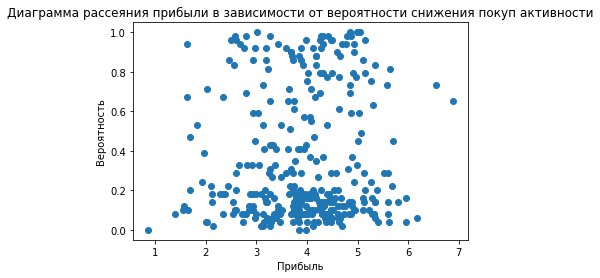

In [72]:
plt.scatter(custom['Прибыль'],custom['proba'], marker='o');
plt.title('Диаграмма рассеяния прибыли в зависимости от вероятности снижения покуп активности');
plt.ylabel('Вероятность');
plt.xlabel('Прибыль');

Мы видим, что плотность значений прибыли выше при более низкой вероятности снижения покупательской активности (примерно до 0.2). Свыше этого значения вероятности значения прибыли колеблятся практически во всем диапазоне возможных значений прибыли. Стоит отметить, что 2 самых высоких значения прибыли соответствуют достаточно высокой вероятности снижения покупательствой активности.

Для анализа рассмотрим группу клиентов с прибылью выше среднего в целом по выборке - выше 4 условных единиц. Порог для вероятности определим из наименьшего значение порога отнесения к классу, при котором precision будет максимальным. 

In [73]:
#объединим в одну таблицу с целевым признаком
test = pd.DataFrame(zip(y_test,proba), columns = ['test','proba'])
test.head()

,test,proba
0,0,0.02
1,1,0.92
2,0,0.20
3,1,0.65
4,1,0.53


In [74]:
#разобьем интвервал proba на несколько значений
thresholds = [round(i,2) for i in np.linspace(0,1,num = 10,endpoint=False)]

# создаём переменную, которая будет хранить список новых колонок
columns = []

# добавим столбцы с новыми предсказаниями в таблицу
for i in thresholds:
    columns.append('pred'+str(i))
    test['pred'+str(i)] = test['proba'].apply(lambda x: 0 if x<=i else 1)
test.sample(5)

,test,proba,pred0.0,pred0.1,pred0.2,pred0.3,pred0.4,pred0.5,pred0.6,pred0.7,pred0.8,pred0.9
308,0,0.20,1,1,1,0,0,0,0,0,0,0
118,1,0.63,1,1,1,1,1,1,1,0,0,0
87,0,0.10,1,1,0,0,0,0,0,0,0,0
265,1,0.92,1,1,1,1,1,1,1,1,1,1
125,0,0.16,1,1,0,0,0,0,0,0,0,0


In [75]:
#зададим расчет и вывод значений через цикл
for i in columns:
    precision = precision_score(test['test'],test[i])
    print(f'{i:<12}: precision ={precision:,.2f}')

pred0.0     : precision =0.38
pred0.1     : precision =0.47
pred0.2     : precision =0.69
pred0.3     : precision =0.83
pred0.4     : precision =0.90
pred0.5     : precision =0.99
pred0.6     : precision =1.00
pred0.7     : precision =1.00
pred0.8     : precision =1.00
pred0.9     : precision =1.00


Итак, в качестве сегмента определим покупателей с вероятностью снижения покупательской активности свыше 0.6 и прибылью свыше 4 у.е.

### Анализ выбранной группы покупателей

Проведем исследовательский анализ выбранного сегмента по группе с максимальной долей покупок по акции (свыше 0.8)

In [76]:
#сохраним срез покупателей с высокой вероятностью снижения покупательской активности,прибылью свыше 4 и
#долей покупок по акции свыше 0.8
custom_money = custom.query('proba>= 0.6 and Прибыль>=4 and Акционные_покупки>0.8')

Сначала проанализируем качественные.Как мы помним из анализа важности, признаки Тип сервиса и Разрешать сообщать практически не оказывают влияение на снижение покупательской активности, поэтому, в целом, на них не стоит акцентировать.Важным является признак Популярная категория 

Оценим размер выручки от каждой категории, динамику изменения выручки по месяцам - совокупной и средней на покупателя.

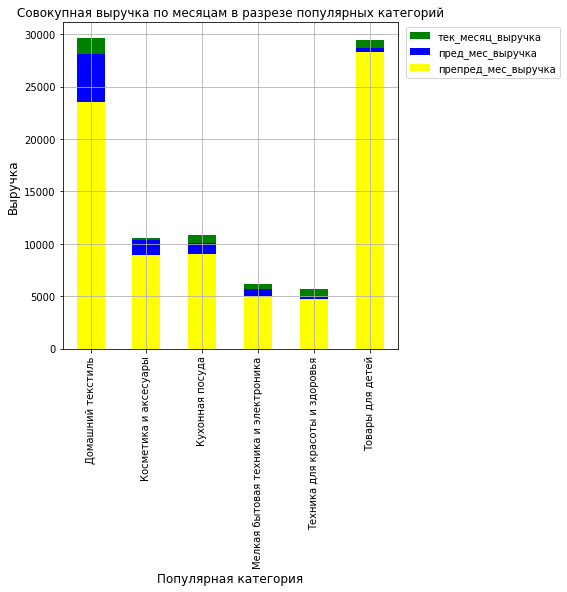

In [77]:
#выведем гистограмму распределения совокупной выручки по месяцам в разрезе популярных категорий
ax = plt.gca()

custom_money.groupby('Популярная_категория')['тек_месяц_выручка'].sum()\
    .plot(kind='bar', ax=ax,color='green',figsize=(6,6),grid=True);

custom_money.groupby('Популярная_категория')['пред_месяц_выручка'].sum()\
    .plot(kind='bar', ax=ax, color='blue',figsize=(6,6),grid=True);
    
custom_money.groupby('Популярная_категория')['препред_мес_выручка'].sum()\
    .plot(kind='bar', ax=ax, color='yellow',figsize=(6,6),grid=True);

plt.ylabel('Выручка', fontsize=12);

plt.xlabel('Популярная категория', fontsize=12);
plt.title('Совокупная выручка по месяцам в разрезе популярных категорий');
ax.legend(['тек_месяц_выручка','пред_мес_выручка','препред_мес_выручка'],bbox_to_anchor=(1.5, 1.0));

По графику распределения совокупной выручки:
 - Домашний текстиль и Товары для детей являются самыми большими категориями по объему выручки,Домашний текстиль также показывает наилучшую по приросту выручки динамику.

 - Техника для красоты и здоровья, Мелкая бытовая техника и электроника принесли меньше всего выручки,

 - Практически отсутствует прирост выручки в текущем месяце по сравнению с предыдущим у категории Косметика и аксессуары.
 
Далее рассмотрим значение средней выручки на покупателя по месяцам 

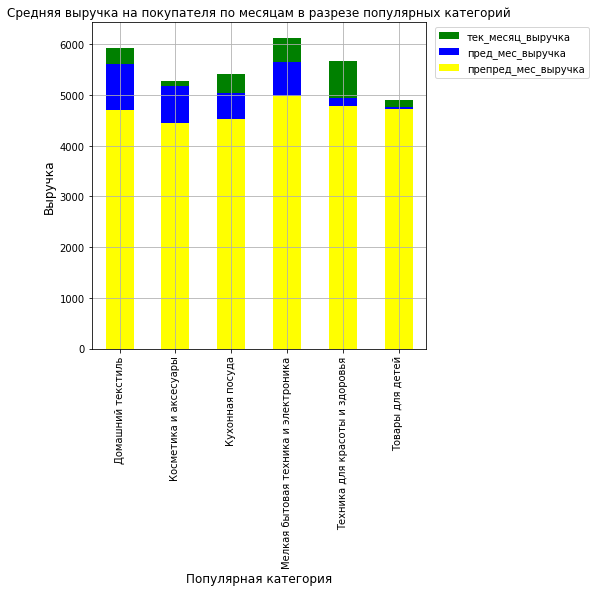

In [78]:
#выведем гистограмму распределения средней выручки по клиенту по месяцам в разрезе популярных категорий
ax = plt.gca()

custom_money.groupby('Популярная_категория')['тек_месяц_выручка'].mean()\
    .plot(kind='bar', ax=ax,color='green',figsize=(6,6),grid=True);

custom_money.groupby('Популярная_категория')['пред_месяц_выручка'].mean()\
    .plot(kind='bar', ax=ax, color='blue',figsize=(6,6),grid=True);
    
custom_money.groupby('Популярная_категория')['препред_мес_выручка'].mean()\
    .plot(kind='bar', ax=ax, color='yellow',figsize=(6,6),grid=True);

plt.ylabel('Выручка', fontsize=12);

plt.xlabel('Популярная категория', fontsize=12);
plt.title('Средняя выручка на покупателя по месяцам в разрезе популярных категорий');
ax.legend(['тек_месяц_выручка','пред_мес_выручка','препред_мес_выручка'],bbox_to_anchor=(1.5, 1.0)); 

По графику средней выручки на покупателя:
 - практически отсутствует прирост выручки за текущий месяц в категориях Косметика и аксессуары,Товары для детей
 - Домашний текстиль показывает наибольший прирост за все время, далее Мелкая бытовая техника и электроника.
 - средняя выручка по категории Техника для красоты и здоровья в текущем месяце приросла больше всех
 
Оценим распределение значений количественных признаков в рассматриваемой группе(для визуальности будет выводить по 4-5 признаков на одном графике) 

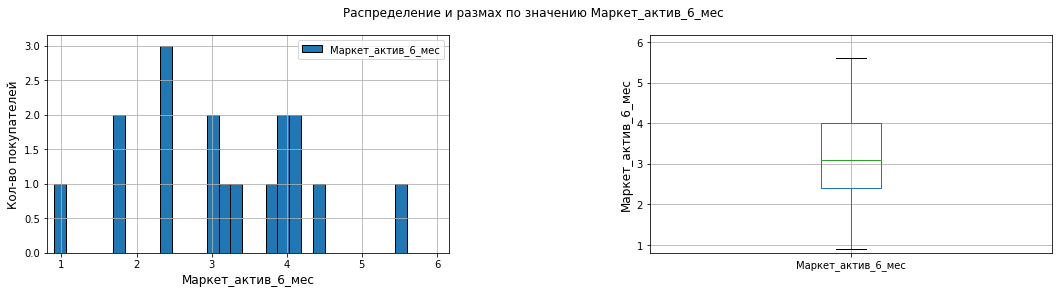

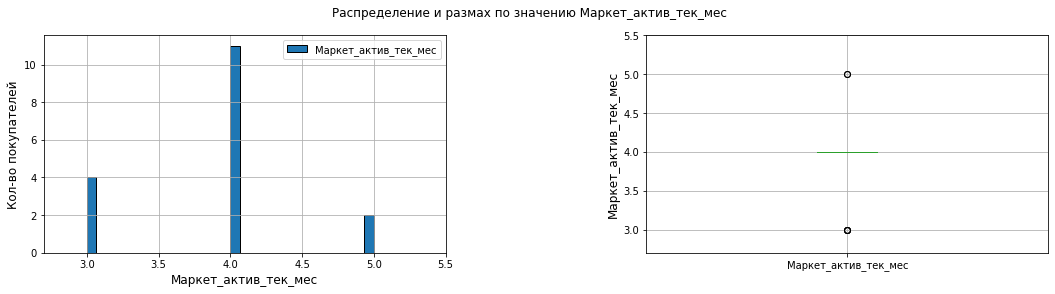

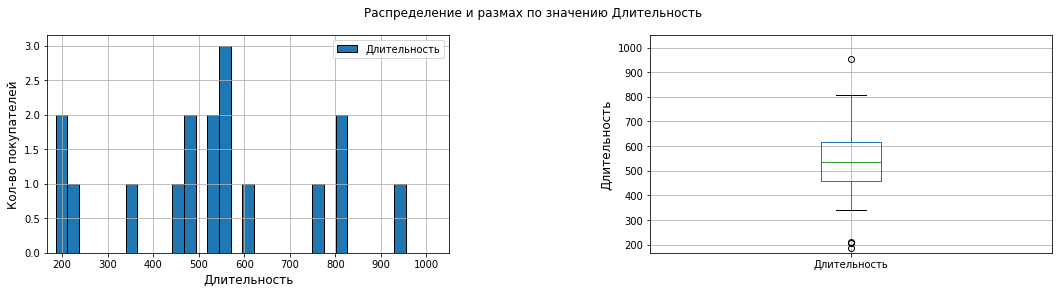

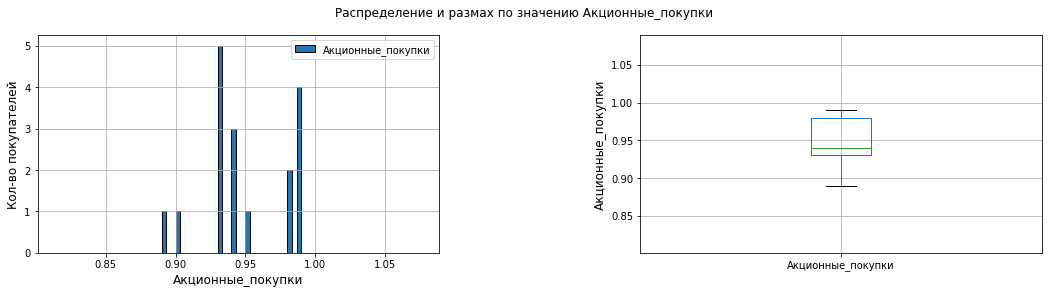

In [79]:
#выведем гистограмму распределения и диаграмму размаха(первые 4 признака)
for column in  custom_money.drop(['proba','Прибыль'],axis=1).select_dtypes(include='number').columns[:4]:
    hist_box(custom_money.drop(['proba','Прибыль'],axis=1).select_dtypes(include='number'),column)

 - Наиболее частым значением средней маркетинговой активности за последние 6 месяцев является около 2.5 - это низкое значение, напомним, что для покупателей с прежней активностью данное значение выше 4-х.
 - Распределение маркетинговой активности за текущий месяц в целом соответствует распределению по всей выборке в целом, также данный признак не является важным,
 - Значение длительности не является важным признаком, значения находятся практически в тех же интервалах, что и в целом по выборке, только максимальные значения чуть ниже чем по выборке в целом,
 - Акционные покупки:преобладающей являются доли 93 и 99%,
  
признаки далее 

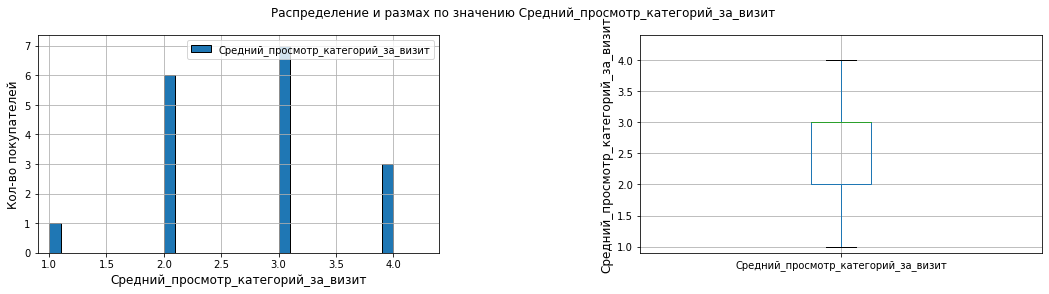

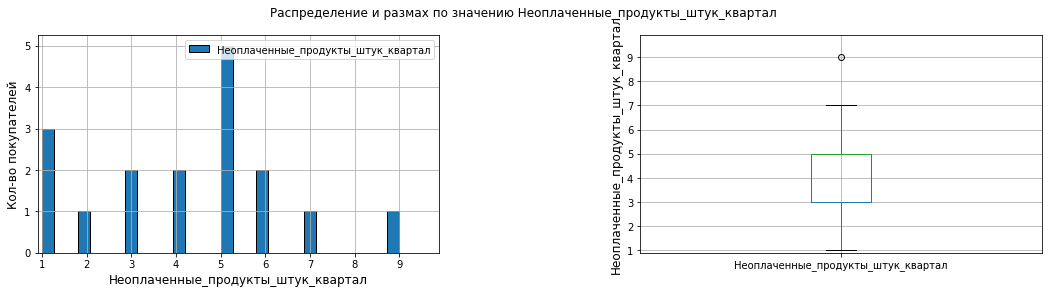

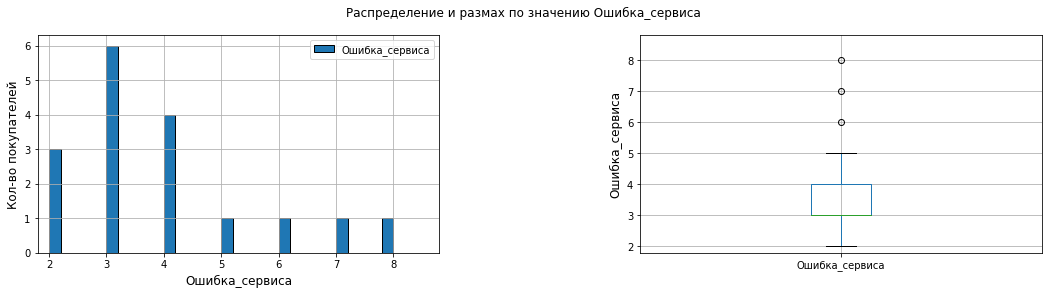

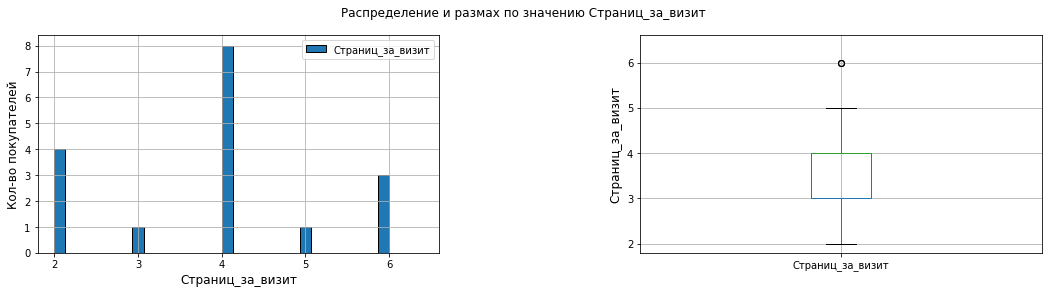

In [80]:
#выведем гистограмму распределения и диаграмму размаха(следующие 4 признака)
for column in  custom_money.drop(['proba','Прибыль'],axis=1).select_dtypes(include='number').columns[4:8]:
    hist_box(custom_money.drop(['proba','Прибыль'],axis=1).select_dtypes(include='number'),column)

 - Средний просмотр категорий за визит: наиболее частыми значениями являются 2 и 3, аналогично распределению по всей выборке в целом, при этом соотношение просмотра более высоких значений (4 и 5) ниже, чем для всей выборки, просмотр 6 категорий полностью отсутствует,
 - Неоплаченные продукты: наиболее частыми значениями являются 2 и 5, данный признак является наименее существенным из важных,
 - Ошибка сервиса: здесь наиболее частое значение 3 даже ниже, чем у покупателей с прежней активностью(4), данный признак несущественный,
 - Страниц за визит: важнейший признак, в нашей группе максимальное значение признака 6 (в то время как при прежней активности 10), наиболее частое значение  4,
 
признаки далее

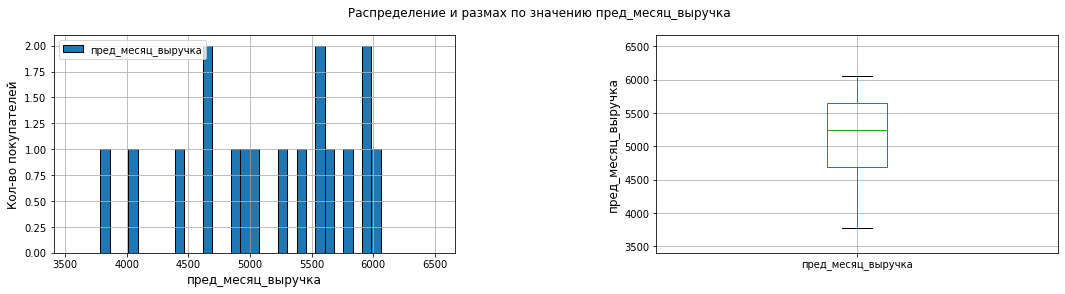

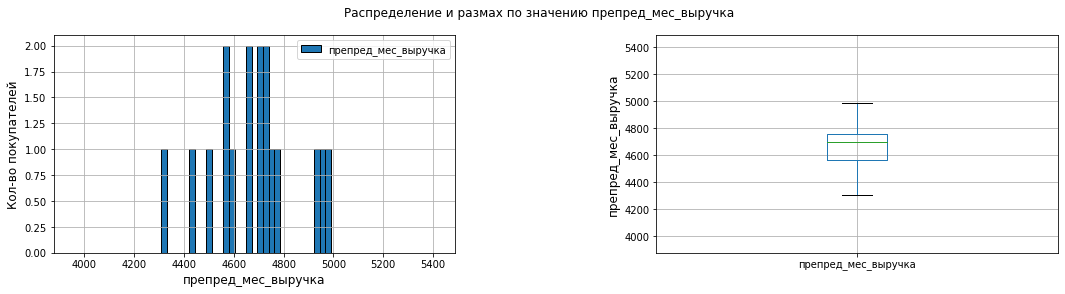

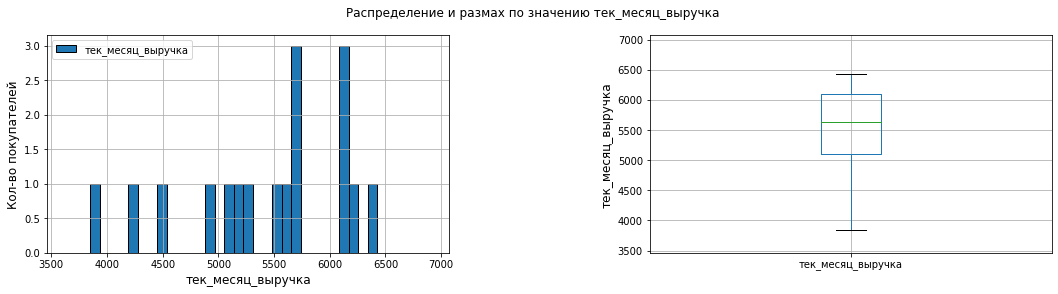

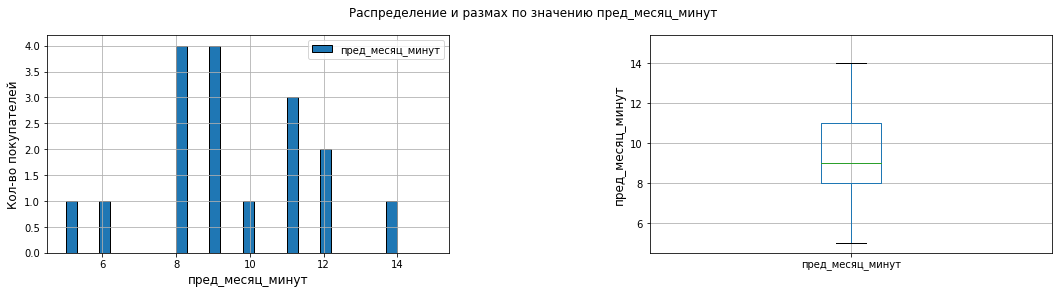

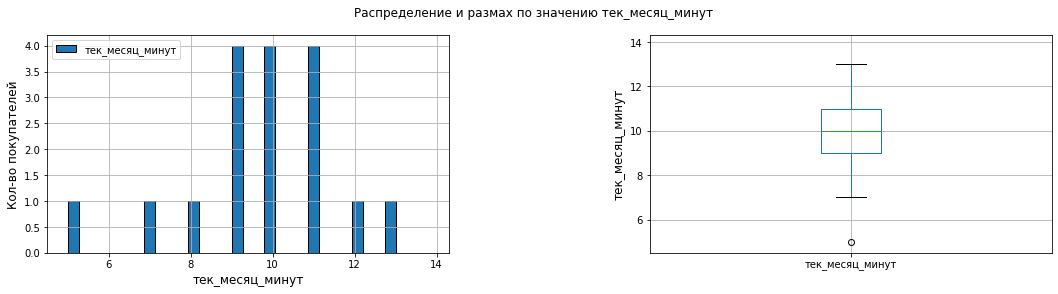

In [81]:
#выведем гистограмму распределения и диаграмму размаха(остальные признаки)
for column in  custom_money.drop(['proba','Прибыль'],axis=1).select_dtypes(include='number').columns[8:]:
    hist_box(custom_money.drop(['proba','Прибыль'],axis=1).select_dtypes(include='number'),column)

 - Выручка за препредыдущий месяц:важный признак,логично завязан на прибыли и активности - чем выше выручка, тем выше прибыль, этот признак скорее следствие всех других,максимальное значение (около 5000) ниже, чем для всей выборки в целом (порядка 5700),
 - Выручка за текущий месяц: значения в целом выше, чем за предыдущий месяц, один из несущественных признаков,
 - Кол-во проведенных минут за предыдущий и текущий месяца входят в топ-3 важнейших признаков, что логично:чем больше покупатель проводит времени, тем больше интересных товаров может найти. Медиана за текущий месяц - 10 минут, в то время как у покупателей с прежней активностью 15, максмиальное значение в текущем месяце по сравнению с предыдущим упало на 1 минуту до 13 минут.  

### Вывод о сегментации

Для увеличения покупательской активности клиентов с высокой вероятностью ее снижения, уровнем прибыльности выше среднего (выше 4 у.е.) и высокой долей акционных покупок (свыше 0.8) следует предложить следующее:
 - привлекать внимание к акционным покупкам в наиболее популярных категориях- Домашний текстиль (имеет самую высокую динамику прироста по месяцам) и Товары для детей, например, сделать подборку акций по этим категориям. Также стоит акцентировать внимание на категориях, по которым рост выручки просел либо практически отсутствует -Косметика и аксессуары, увеличивать средний просмотр категорий: например, теми же акциями, большим кол-вом предложений других товаров на одной странице (например, "вам может быть интересно следующее"),
 - увеличивать маркетинговую активность (у покупателей рассматриваемой группы среднее значение по данному признаку почти в 1.8 раз ниже, чем у покупателей с прежней покупательской активностью), при этом на постоянной основе - в этом плане важна именно длительность работы с клиентом ( как видим маркетинговая активность в текущем месяце не столь важна, как за 6 месяцев в среднем): здесь опять же можно увеличивать рассылку акционных товаров в наиболее просматриваемых категориях  
 - относится ко всем группам покупателям, но также стоит отметить - необходимо улучшать привлекательность и удобство интерфейса сайта:чем больше покупатель будет находиться на сайте, тем больше вероятность того, что он увидит нужные ему товары, заинтересуется какими-то другими категориями товаров

## Общий вывод

В рамках проекта было поставлено и реализовано 2 задачи:
  - построить модель, которая предскажет вероятность снижения покупательской активности клиента в следующие три месяца,
  
  - используя данные модели и данные о прибыльности клиентов, требовалось выделить сегменты покупателей и разработать для них персонализированные предложения.  

Данные для работы были представлены 4-мя таблицами с даными  о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении, с данными о выручке, которую получает магазин с покупателя, с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода и среднемесячной прибылью покупателя за последние 3 месяца.

В рамках предобработки выявлено, что пропуски в данных и явные дубликаты отсутствуют, обработаны неявные дубликаты (опечатки), все данные приведены к корректному типу.

В рамках исследовательского анализа(более подробно см. вывод к разделу Исследовательский анализ) выявлено, что:
  - категориальные данные в файле о покупателях несбалансированы, 
  - проанализированы статистика по количественным показателям о поведении покупателей, 
  - выручка и ее медианное значение увеличивается из месяца в месяц, также увеличивается возможный интервал выручки. Исключено 1 аномальное значение выручки (более чем в 10 раз превышает следующее по уровню значение),
  - распределение времени на сайте в предыдущем и текущем месяцах в целом одинаковое,несущественно сократилось в текущем месяце,
  - прибыль в интервале от 0.86 у.е. до 7.43 у.е., медиана близка к среднему - 4 у.е.,распределение является нормальным.
  
Для построения модели осуществлено следующее:  
- Данные из всех таблиц, кроме данных о прибыли, объединены,
- Проведен корреляционный анализ признаков: согласно коэф-та Фи, больше всего покупательская активность коррелирует с кол-вом страниц за визит (0.75), временем, проведенном на сайте - в предыдущем месяце (0.69) и в текущем месяце(0.58),средним просмотром страниц за визит (0.54) и акционными покупками. Согласно коэф-та Спирмена присутствуют 2 признака с очень высокой корреляцией - выручка за текущий и предыдущий месяца (значение коэф-та 0.88).
- С помощью пайпланой было автоматизировано обучено 4 модели (KNeighborsClassifier,DecisionTreeClassifier, LogisticRegression,SVC) с разными гиперпараметрами, из которых была выбрана лучшая путем поиска наилучшего значения ROC-AUC: метрика выбрана, т.к. она отлично подходит для бинарной классификации с несбалансированной выборкой. Наилучшей моделью является KNeighborsClassifier с к=49
- Проведен анализ важности признаков для лучшей модели методом SHAP: ими являются акционные покупки, общее время, проведенное на сайте (в первую очередь за текущий месяц, далее за предыдущий), кол-во просмотренных страниц за визит,популярная категория, выручка за препредыдущий месяц,средняя маркетинговая активность за последние 6 мес,средний просмотр категорий за визит и кол-во неоплаченных продуктов в квартал.

В качестве сегмента для дописследования выбрана группа покупателей с высокой вероятностью снижения покупательской активности (выше 60%), прибылью выше среднего (выше 4у.е.) и высокой долей акционных покупок ( свыше 0.8). Исходя из уровня важности признаков, по которым лучшая модель относит клиентов к сниженному или прежнему уровню покупательской активности, для выбранного сегмента предложено следующее:
 - привлекать внимание к акционным покупкам в наиболее популярных категориях- Домашний текстиль (имеет самую высокую динамику прироста по месяцам) и Товары для детей, например, сделать подборку акций по этим категориям. Также стоит акцентировать внимание на категориях, по которым рост выручки просел либо практически отсутствует -Косметика и аксессуары, увеличивать средний просмотр категорий: например, теми же акциями, большим кол-вом предложений других товаров на одной странице (например, "вам может быть интересно следующее"),
 - увеличивать маркетинговую активность (у покупателей рассматриваемой группы среднее значение по данному признаку почти в 1.8 раз ниже, чем у покупателей с прежней покупательской активностью), при этом на постоянной основе - в этом плане важна именно длительность работы с клиентом (маркетинговая активность в текущем месяце не столь важна, как за 6 месяцев в среднем): здесь опять же можно увеличивать рассылку акционных товаров в наиболее просматриваемых категориях,  
 - относится ко всем группам покупателям, но также стоит отметить - необходимо улучшать привлекательность и удобство интерфейса сайта:чем больше покупатель будет находиться на сайте, тем больше вероятность того, что он увидит нужные ему товары, заинтересуется какими-то другими категориями товаров
